# Capstone Project: Audio Classification for Emotions

### 1.0 Background

Communication plays a vital role in building and maintaining relationships with one another. Emotional projection is one of the first telltale signs that we notice or observed during a conversation. Our emotions can not only be portrayed by what words we say but also how we say them. Changes in the rate of speech, pitch and the degree of loudness or softness of your voice are some examples to help to convey emotional states like angry, sad and happy.

### 2.0 Problem Statement

1) **What is the problem?**
    - Low Emotional quotient (EQ) is the inability to distinguish emotions in both self and others.
    - Cognitive Empathy is the lack of understanding for how others feel.
    - Alexithymia is when a person has difficulty identifying and expressing emotions.

1) **Why do we need to solve it?**
    - Poor performance at school or work from lack of communication, inability to express or understand their grievances.
    - Degrading Physical & Mental well-being due to stress in turn may lead to a more serious situation such as depression or suicide.
    - Failure to foster relationships may lead to them being dysfunctional.
    - Low Social Intelligence due to absence of experience with people.
    - Violent tendencies induced by stress or confusion

1) **How are we going to solve it?**
    - CNN Deep Learning
    - Prediction Model to predict emotion from speech
    - Application to provide educational aid

1) **What will be the benefit?**
    - Given the ability to identify root emotions.
    - Improving and also further enforcing their knowledge related to emotions

### 3.0 Datasets and file format

- **Datasets**
1) ***Toronto emotional speech set (TESS)*** [(source)](https://www.kaggle.com/datasets/ejlok1/toronto-emotional-speech-set-tess)
<br>In total there are 2800 audio files(WAV format) which are categorized by two voice actors portraying 7 emotions angry, disgust, fear, happy, neutral, surprise & sad.
For each emotion, there are a set of 200 words which were spoken as "Say the word _".

1) ***Emotional Speech Dataset (ESD)*** [(source)](https://github.com/HLTSingapore/Emotional-Speech-Data )
<br>This dataset contains 35000 files, 350 parallel utterances spoken by 10 native Mandarin speakers, and 10 English speakers with 5 emotional states (neutral, happy, angry, sad and surprise)

1) ***Ryerson Audio-Visual Database of Emotional Speech and Song (RAVDESS)*** [(source)](https://www.kaggle.com/datasets/uwrfkaggler/ravdess-emotional-speech-audio )
<br>This portion of the RAVDESS contains 1440 files: 60 trials per actor x 24 actors = 1440. The RAVDESS contains 24 professional actors (12 female, 12 male), vocalizing two lexically-matched statements in a neutral North American accent. Speech emotions includes calm, happy, sad, angry, fearful, surprise, and disgust expressions. Each expression is produced at two levels of emotional intensity (normal, strong), with an additional neutral expression.
Emotion (01 = neutral, 02 = calm, 03 = happy, 04 = sad, 05 = angry, 06 = fearful, 07 = disgust, 08 = surprised)

- **Audio File format** [(source)](https://www.izotope.com/en/learn/whats-the-difference-between-file-formats.html)
File format will be using is .wav file.

     Why .wav file?
1) One of the more popular digital audio formats
2) Gold standard in studio recording
3) It captures and recreate and original audio waveform at the highest quality with minimal distortion or loss
4) The closest mathematical/digital representation of the original audio waveform 

### 4.0 Imports

In [1]:
# import fundamental libraries
import os
import sys
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm.notebook import tqdm
from ipywidgets import Output, GridspecLayout

# import libraries for audio analytics
import librosa
from pydub import AudioSegment
import librosa.display
import IPython.display as ipd

# import libraries for preprocessing modeling
from sklearn.preprocessing import OneHotEncoder, normalize
from sklearn.model_selection import train_test_split

# import libraries for preprocessing modeling
import tensorflow as tf
from tensorflow.keras import models, layers
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPooling2D,Normalization 
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam, Adamax

# import libraries for model evaluations
from sklearn.metrics import confusion_matrix, classification_report, matthews_corrcoef
# import visualkeras

# import libraries for saving and loading .h5 files
import h5py

C:\Users\zuans\.conda\envs\dsi-sg32\lib\site-packages\pydub\utils.py:170: RuntimeWarning: Couldn't find ffmpeg or avconv - defaulting to ffmpeg, but may not work
  warn("Couldn't find ffmpeg or avconv - defaulting to ffmpeg, but may not work", RuntimeWarning)


In [2]:
from IPython.core.display import HTML
table_css = 'table {align:left;display:block} '
HTML('<style>{}</style>'.format(table_css))

### 5.0 Construct Metadata Dataframe

- Getting meta data for each dataset
- Combine them into 1 dataframe

#### 5.1 TESS Metadata

**Creating TESS Metadata**

Tess Metadata is created from the file path by segregating and sorting into a data frame for wav path, category and voice actors.


In [3]:
# get .wav names and folder names from path directory
wav_list = [x[2] for x in os.walk('.\TESS Toronto emotional speech set data')][1:]
folders = [x for x in os.walk('.\TESS Toronto emotional speech set data')][0][1:2][0]

In [4]:
# from wav and folder name list, make a meta dataframe for referencing purposes
def make_tess_metadata(folders,wav_list):
    fold_col=[]
    path_col=[]
    for wavs, folder in zip(wav_list,folders):
        for wav in wavs:
            path = './TESS Toronto emotional speech set data'+ '/' + folder + '/' + wav
            path_col.append(path)
            fold_col.append(folder)
    meta = pd.DataFrame({'fold':fold_col,'path':path_col})
    meta['actor']= meta.fold.str.lower().str.split('_',n=1,expand = True)[0].replace({'oaf':'old','yaf':'young'})
    meta['category'] = meta.fold.str.lower().str.split('_',n=1,expand = True)[1]
    meta.drop('fold',axis =1, inplace = True)
    return meta

In [5]:
# call function to save meta dataframe as tess_meta
tess_meta = make_tess_metadata(folders,wav_list)

In [6]:
# function to pick 1st wav as an example for every emotion available
def get_tess_sample(df):
    fold_list =[]
    path_list =[]
    catname_list =[]
    for cat in df['category'].value_counts().index.tolist():
        path_list.append(df[(df['category'] == cat) &(df['actor'] =='young')].reset_index()['path'][0])
        catname_list.append(cat)
    temp_dict = {'category':catname_list,'path':path_list}
    dataf = pd.DataFrame(temp_dict)
    return dataf

In [7]:
# function to read .wav file and display in juypter notebook
def getsound_raw_wave(df):
    cat_wav = df['category'].tolist()
    path_wav = df['path'].tolist()
    for cat,path in zip(cat_wav,path_wav):
        filename = path
        data_ori, sample_rate = librosa.load(filename)
        data, _ = librosa.effects.trim(data_ori)
        
        grid = GridspecLayout(1, 2, align_items='center')
        out = Output()
        
        with out:
            fig, ax = plt.subplots(figsize=(8, 1))
            librosa.display.waveshow(data, sr=sample_rate, ax=ax)
            ax.set_title(f'Wave Sample of {cat}')
            plt.close(fig)
            ipd.display(ax.figure)            
        grid[0, 0] = out
        out = Output()
            
        with out:
            print((f'Audio Sample of {cat}'))
            ipd.display(ipd.Audio(data=data, rate=sample_rate))
            
        grid[0, 1] = out
        out = Output()
        
        ipd.display(grid)

In [8]:
# high-level function to incorperate the two function above
def show_tess_example(df):
    sample_df = get_tess_sample(df)
    getsound_raw_wave(sample_df)  

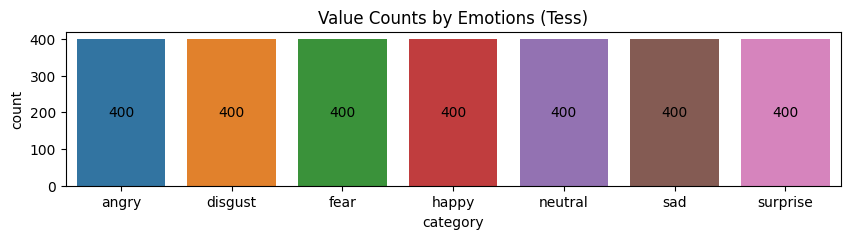

In [9]:
# plot countplot to confirm every emotion have 400 wav files
plt.figure(figsize=(10, 2))
t = sns.countplot(x = tess_meta['category'])
t.bar_label(t.containers[0],label_type = 'center')
plt.title('Value Counts by Emotions (Tess)');

In [10]:
# show example of the 7 emotions from TESS meta and its audio.
show_tess_example(tess_meta)

GridspecLayout(children=(Output(layout=Layout(grid_area='widget001')), Output(layout=Layout(grid_area='widget0…

GridspecLayout(children=(Output(layout=Layout(grid_area='widget001')), Output(layout=Layout(grid_area='widget0…

GridspecLayout(children=(Output(layout=Layout(grid_area='widget001')), Output(layout=Layout(grid_area='widget0…

GridspecLayout(children=(Output(layout=Layout(grid_area='widget001')), Output(layout=Layout(grid_area='widget0…

GridspecLayout(children=(Output(layout=Layout(grid_area='widget001')), Output(layout=Layout(grid_area='widget0…

GridspecLayout(children=(Output(layout=Layout(grid_area='widget001')), Output(layout=Layout(grid_area='widget0…

GridspecLayout(children=(Output(layout=Layout(grid_area='widget001')), Output(layout=Layout(grid_area='widget0…

#### 5.2 ESD Metadata

**Creating ESD Metadata**

ESD Metadata is created from the file path by segregating and sorting into a data frame for wav path, category and voice actors.

In [11]:
# ESD was originally sorted into many folders. Below is to list out everything in the folder for future reference.
speaker_fold = [x[1] for x in os.walk('.\Emotional Speech Dataset (ESD)')][0]
emo_fold = [x[1] for x in os.walk('.\Emotional Speech Dataset (ESD)')][1]
model_fold = [x[1] for x in os.walk('.\Emotional Speech Dataset (ESD)')][2]
esd_wav = [x[2] for x in os.walk('.\Emotional Speech Dataset (ESD)')][3:]
not_wav = [[item] for items in esd_wav for item in items if item.endswith('.wav') != True or item == []]
test_wav = [items for items in esd_wav if items not in not_wav]
test_wav = list(filter(None, test_wav))

In [12]:
# create function to make ESD Meta dataframe:
def make_esd_metadata(speakers, emos, mdl, wavs_lis):
    actor_col=[]
    cat_col=[]
    path_col = []
    num = 0
    for speaker in speakers:
        for emo in emos:
            for split in mdl:
                if num == len(wavs_lis) :
                    break
                else:
                    tempwav = wavs_lis[num]
                    num +=1
                    for wav in tempwav:
                        actor_col.append(speaker)                        
                        cat_col.append(emo.lower())
                        path = './Emotional Speech Dataset (ESD)/' + speaker + '/'+ emo + '/'+ split + '/' + wav  
                        path_col.append(path)

    meta = pd.DataFrame({'path':path_col,'actor':actor_col,'category':cat_col})
    
    return meta

In [13]:
# call function to create and save the metadata as esd_meta
esd_meta = make_esd_metadata(speakers = speaker_fold , emos = emo_fold , mdl = model_fold, wavs_lis = test_wav) 

In [14]:
# get samples for every emotion from only Voice actor 11 in ESD
def get_esd_sample(df):
    path=[]
    catname_list =[]
    for cat in df['category'].value_counts().index.tolist():
        temp = df[(df['category'] == cat) & (df['actor'] == '0011') & (df['path'].str.contains('train'))].reset_index(drop = True).iloc[1]
        path.append(temp['path'])
        catname_list.append(cat)
    temp_dict = {'path':path,'category':catname_list,}
    dataf = pd.DataFrame(temp_dict).reset_index(drop = True)
    return dataf

In [15]:
# high-level function to combine the twp function above
def show_esd_example(df):
    sample_df = get_esd_sample(df)
    getsound_raw_wave(sample_df)  

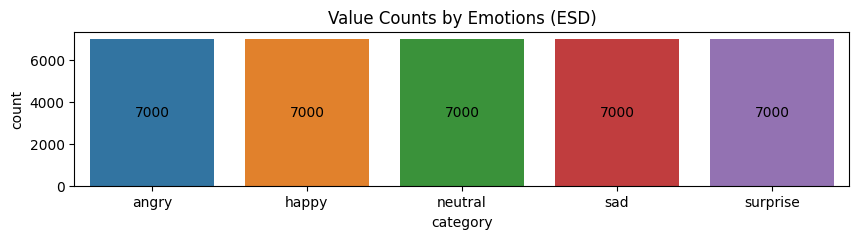

In [16]:
# plot countplot to check the number of wav files for each emotions in ESD
plt.figure(figsize=(10, 2))
e = sns.countplot(x = esd_meta['category'])
e.bar_label(e.containers[0],label_type = 'center')
plt.title('Value Counts by Emotions (ESD)');

In [17]:
# call function to show example from ESD dataset
show_esd_example(esd_meta)

GridspecLayout(children=(Output(layout=Layout(grid_area='widget001')), Output(layout=Layout(grid_area='widget0…

GridspecLayout(children=(Output(layout=Layout(grid_area='widget001')), Output(layout=Layout(grid_area='widget0…

GridspecLayout(children=(Output(layout=Layout(grid_area='widget001')), Output(layout=Layout(grid_area='widget0…

GridspecLayout(children=(Output(layout=Layout(grid_area='widget001')), Output(layout=Layout(grid_area='widget0…

GridspecLayout(children=(Output(layout=Layout(grid_area='widget001')), Output(layout=Layout(grid_area='widget0…

#### 5.3 RAVDESS Metadata

**Creating RAVDESS Metadata**

RAVDESS Metadata is created from the file path by segregating and sorting into a data frame for wav path, category and voice actors.

In [18]:
# create alist for actor folder and wav file names
actor_fold = [x[1] for x in os.walk('.\RAVDESS Emotional speech audio')][0]
RAVDESS_wav = [x[2] for x in os.walk('.\RAVDESS Emotional speech audio')][1:]

In [19]:
# function to make meta data frame for RAVDESS dataset
def make_ravdess_metadata(va,wavs):
    actor_col=[]
    cat_col=[]
    path_col = []
    num = 0
    for speaker,wav in zip(va,wavs):
        for item in wav:
            actor_col.append(speaker) 
            emo = item.split('-')[2]
            cat_col.append(emo)
            path = './RAVDESS Emotional speech audio/' + speaker + '/' + item 
            path_col.append(path)

    meta = pd.DataFrame({'path':path_col,'actor':actor_col,'category':cat_col})
    meta['category'] = meta['category'].replace({'01' : 'neutral', '02' : 'calm', '03' : 'happy', 
                                         '04' : 'sad', '05' : 'angry', '06' : 'fear', 
                                         '07' : 'disgust','08' : 'surprise'})
    return meta

In [20]:
# call function to create meta data and save under ravdess_meta
ravdess_meta = make_ravdess_metadata(va = actor_fold,wavs=RAVDESS_wav)

In [21]:
# get wav sample for each emotion from voice actor 1
def get_ravdess_sample(df):
    path=[]
    catname_list =[]
    for cat in df['category'].value_counts().index.tolist():
        temp = df[(df['category'] == cat) & (df['actor'] == 'Actor_01')].reset_index(drop = True).iloc[1]
        path.append(temp['path'])
        catname_list.append(cat)
    temp_dict = {'path':path,'category':catname_list,}
    dataf = pd.DataFrame(temp_dict).reset_index(drop = True)
    return dataf

In [22]:
# high-level function to integrate above previous two function
def show_ravdess_example(df):
    sample_df = get_ravdess_sample(df)
    getsound_raw_wave(sample_df)  

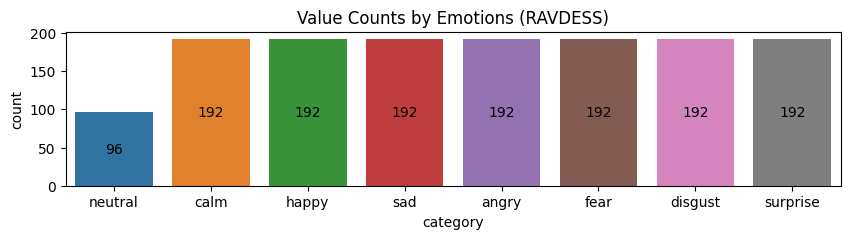

In [23]:
# plot count plot to see how many wav files for each emotion.
# There is no strong intensity for the 'neutral' emotion.
plt.figure(figsize=(10, 2))
r = sns.countplot(x = ravdess_meta['category'])
r.bar_label(r.containers[0],label_type = 'center')
plt.title('Value Counts by Emotions (RAVDESS)');

#### 5.4 Combined Metadata

**Creating Combine Metadata**

Combine all the 3 meta data frames into 1.<br> 
Classes for disgust, fear and calm will the drop due to huge gap in the number of files. It might lead to misclassification by hindering the models learning capabulities.

In [24]:
# concatenate all three meta data frame into one combine dataframe
comb_meta = pd.concat([tess_meta, esd_meta,ravdess_meta], ignore_index=True).reset_index(drop = True)

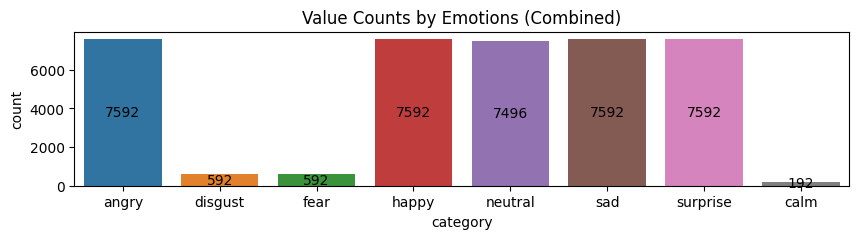

In [25]:
# plot to check class balance
plt.figure(figsize=(10, 2))
c = sns.countplot(x = comb_meta['category'])
c.bar_label(c.containers[0],label_type = 'center')
plt.title('Value Counts by Emotions (Combined)');

- Dropping disgust, fear & calm due to low observations

In [26]:
# dropping classes with low observations
to_drop = comb_meta[(comb_meta['category'] == 'disgust') | (comb_meta['category'] == 'fear') | 
          (comb_meta['category'] == 'calm')].index
new_comb_meta = comb_meta.drop(to_drop).reset_index(drop = True)

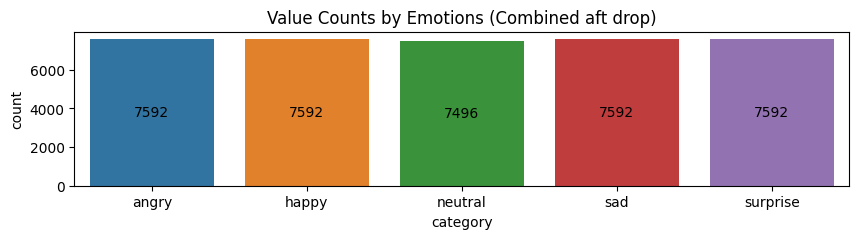

In [27]:
# double check class balance after dropping disgust, fear & calm
plt.figure(figsize=(10, 2))
nc = sns.countplot(x = new_comb_meta['category'])
nc.bar_label(nc.containers[0],label_type = 'center')
plt.title('Value Counts by Emotions (Combined aft drop)');

**Total audio files: 37864**

### 6.0 Audio features Data processing

Generating basic audio features for audio format.
- **Basic audio features**
    - Channels: 1 for mono and 2 for stereo audio
    - Bit Depth: 1 means 8-bit and 2 means 16-bit
    - Sample rate: frequency of samples used (in Hertz)
    - Sample width: the number of bytes for each sample for a channel.
    - Length: the audio file length (in milliseconds)
    - Sample count: the number of samples in the audio (sample rate(KHz) * duration(s))
    - Intensity: loudness in dB relative to the full scale. 0 dBFS represents the highest possible level in digital gear. All other measurements expressed in terms of dBFS will always be less than 0 dB (negative numbers)
    

***Found 1 corrupted file: YAF_germ_angry.wav***

In [28]:
# function to add audio features from metaDF
def add_audio_parameters(df):
    chn = []
    sw = []
    fr = []
    fw = []
    leng = []
    fc = []
    inten = []
    corrupted = './TESS Toronto emotional speech set data/YAF_angry/YAF_germ_angry.wav'
    path_lis = df.path.tolist()
    for path in tqdm(path_lis):
        if path == corrupted:# found 1 wav file corrupted will replace with nan.
            chn.append(np.nan)
            sw.append(np.nan)
            fr.append(np.nan)
            fw.append(np.nan)
            leng.append(np.nan)
            fc.append(np.nan)
            inten.append(np.nan)        
        else:
            audio_segment = AudioSegment.from_file(path) # using Audio segment to read file
            chn.append(audio_segment.channels) # get number of channels
            sw.append(audio_segment.sample_width) # get sample width
            fr.append(audio_segment.frame_rate) # get frame rate
            fw.append(audio_segment.frame_width) # get frame width
            leng.append(len(audio_segment)) # get length of audio
            fc.append(audio_segment.frame_count()) # get frame count
            inten.append(audio_segment.dBFS) # get sound intensity
    df['channels'] = chn
    df['sample width'] = sw
    df['sample rate'] = fr
    df['sample width'] = fw
    df['length (ms)'] = leng
    df['sample count'] = fc
    df['intensity'] = inten
    return df    

In [29]:
new_comb_meta = add_audio_parameters(new_comb_meta)

  0%|          | 0/37864 [00:00<?, ?it/s]

- **Channels**
    - Found 2 files having 2 channels (Stereo) (By using librosa to load an audio file will make it 1 channel unless the argument for mono=False)

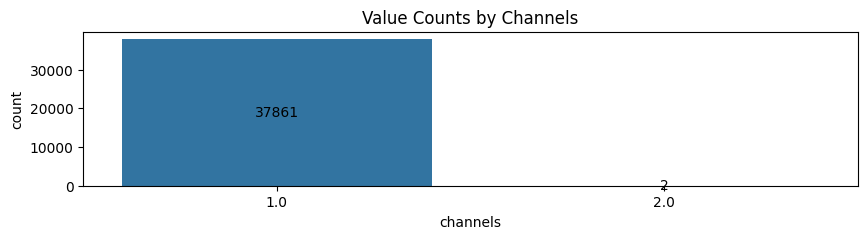

In [30]:
plt.figure(figsize=(10, 2))
chn = sns.countplot(x = new_comb_meta['channels'])
chn.bar_label(chn.containers[0],label_type = 'center')
plt.title('Value Counts by Channels');

- **Bit depth**
    - All audio files are in 16-bit digital audio which has a maximum dynamic range of 96dB 

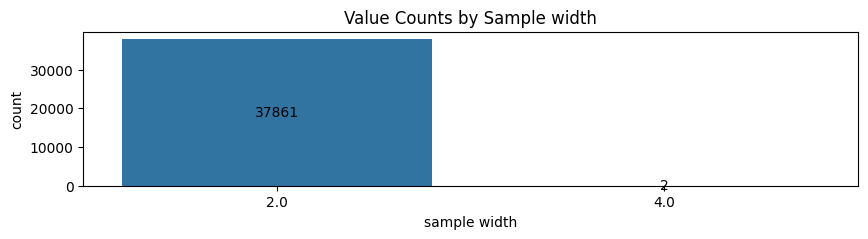

In [31]:
plt.figure(figsize=(10, 2))
sw = sns.countplot(x = new_comb_meta['sample width'])
sw .bar_label(sw.containers[0],label_type = 'center')
plt.title('Value Counts by Sample width');

- **Sample Rate**
    - Found files to have 3 types of Frame rate 16000 , 24414 , 48000 (By using librosa to load an audio file will make it 22050 Hz unless the argument for sr=None then original frame rate will be )
    - Standardize Frame rate to 22050 Hz which is enough to differentiate audio

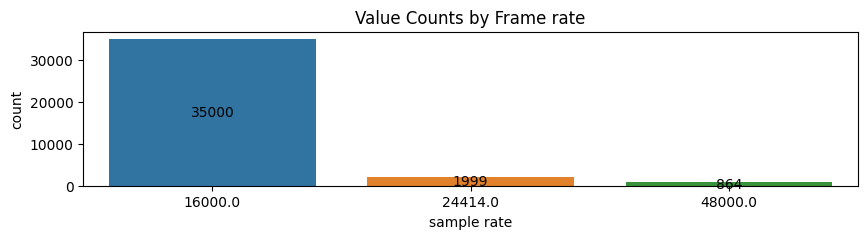

In [32]:
plt.figure(figsize=(10, 2))
fr = sns.countplot(x = new_comb_meta['sample rate'])
fr .bar_label(fr.containers[0],label_type = 'center')
plt.title('Value Counts by Frame rate');

- **Sample width**
    - Found 2 files having 4 bytes for each sample. once we load with librosa for mono = True, the 2 file will have 2 bytes for each frame

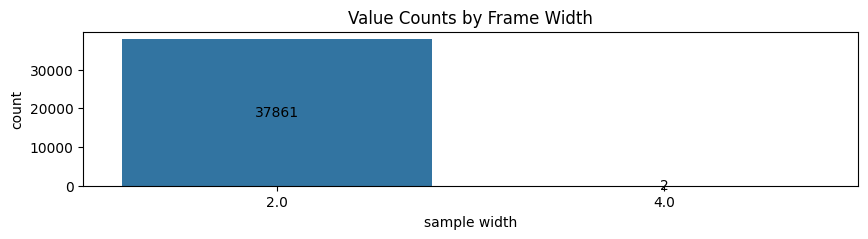

In [33]:
plt.figure(figsize=(10, 2))
fw = sns.countplot(x = new_comb_meta['sample width'])
fw .bar_label(fw.containers[0],label_type = 'center')
plt.title('Value Counts by Frame Width');

- **Audio length**
    - Max audio length: 8080ms
    - Min audio length: 1139ms
    - Most common audio length: 3470ms

Max audio length: 8080ms
Min audio length: 1139ms
Most common audio length: 3470ms


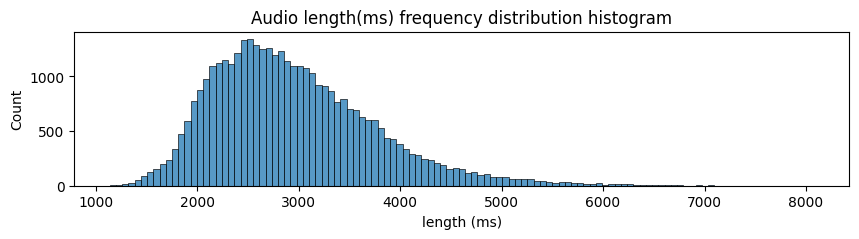

In [34]:
plt.figure(figsize=(10, 2))
ln = sns.histplot(x = new_comb_meta['length (ms)'])
plt.title('Audio length(ms) frequency distribution histogram')

mx = new_comb_meta['length (ms)'].max()
mn = new_comb_meta['length (ms)'].min()
md = new_comb_meta['length (ms)'].mode()[0]
print(f'Max audio length: {mx:0.0f}ms')
print(f'Min audio length: {mn:0.0f}ms')
print(f'Most common audio length: {md:0.0f}ms')

- **Sample count**
    - Found sample count has 2 population. this is mainly due to the different frame rate.
    - Frame count are related to frame rate so after standardizing Frame rate to 22050 with librosa those with frame rate of 48000 will fall in the same population

Max sample count: 129280
Min sample count: 18224
Most common sample count: 38720


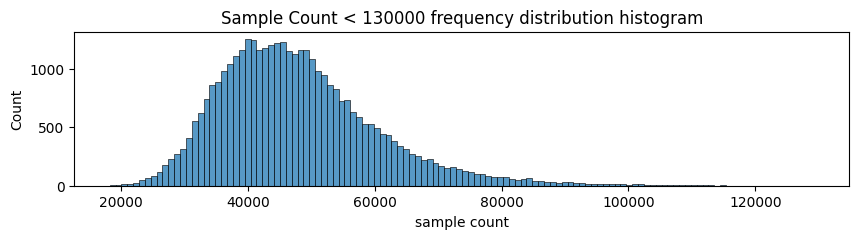

In [35]:
plt.figure(figsize=(10, 2))
fc = sns.histplot(x = new_comb_meta[new_comb_meta['sample count'] < 130000]['sample count'])
plt.title('Sample Count < 130000 frequency distribution histogram');
mx_below130k = new_comb_meta[new_comb_meta['sample count'] < 130000]['sample count'].max()
mn_below130k = new_comb_meta[new_comb_meta['sample count'] < 130000]['sample count'].min()
md_below130k = new_comb_meta[new_comb_meta['sample count'] < 130000]['sample count'].mode()[0]
print(f'Max sample count: {mx_below130k:0.0f}')
print(f'Min sample count: {mn_below130k:0.0f}')
print(f'Most common sample count: {md_below130k:0.0f}')

Max audio length: 245045
Min audio length: 142542
Most common audio length: 168168


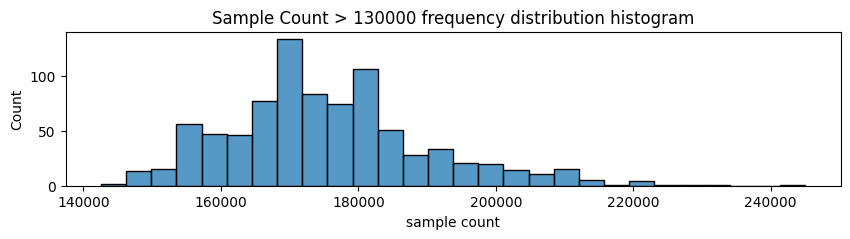

In [36]:
plt.figure(figsize=(10, 2))
fc = sns.histplot(x = new_comb_meta[new_comb_meta['sample count']> 130000]['sample count'])
plt.title('Sample Count > 130000 frequency distribution histogram');
mx_above130k = new_comb_meta[new_comb_meta['sample count'] > 130000]['sample count'].max()
mn_above130k = new_comb_meta[new_comb_meta['sample count'] > 130000]['sample count'].min()
md_above130k = new_comb_meta[new_comb_meta['sample count'] > 130000]['sample count'].mode()[0]
print(f'Max audio length: {mx_above130k:0.0f}')
print(f'Min audio length: {mn_above130k:0.0f}')
print(f'Most common audio length: {md_above130k:0.0f}')

- **Intensity**
    - Loudest audio: -14dBFS
    - Softest audio: -64dBFS
    - Most common loudness audio: -33dBFS

Loudest audio: -14dBFS
Softest audio: -64dBFS
Most common loudness audio: -33dBFS


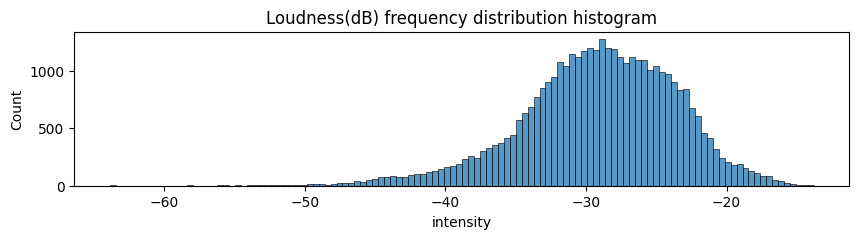

In [37]:
plt.figure(figsize=(10, 2))
inten = sns.histplot(x = new_comb_meta['intensity'])
inten.bar_label(sw.containers[0],label_type = 'center')
plt.title('Loudness(dB) frequency distribution histogram');
mx_it = new_comb_meta['intensity'].max()
mn_it = new_comb_meta['intensity'].min()
md_it = new_comb_meta['intensity'].mode()[0]
print(f'Loudest audio: {mx_it:0.0f}dBFS')
print(f'Softest audio: {mn_it:0.0f}dBFS')
print(f'Most common loudness audio: {md_it:0.0f}dBFS')

### 7.0 Feature Extraction for Audio Analytics [(source)](https://analyticsindiamag.com/a-tutorial-on-spectral-feature-extraction-for-audio-analytics/)
We will be exploring the following Audio features and pick 6 best to train our model.

1) Chromagram
2) Pitch-Decibel analysis
    - Melspectrogram
    - Mel-Frequency Cepstral Coefficients (MFCCs)
1) Spectral analysis
    - Spectral RollOff 
    - Spectral Bandwidth
    - Spectral Contrast
1) Tonal Centroid Features (Tonnetz)
1) Zero-Crossing Rate
1) RMS Energy
---

In [38]:
# function to get 2nd row for each emotion as an example
def get_newmeta_sample(df):
    path=[]
    catname_list =[]
    for cat in df['category'].value_counts().index.tolist():
        temp = df[(df['category'] == cat)].reset_index(drop = True).iloc[1]
        path.append(temp['path'])
        catname_list.append(cat)
    temp_dict = {'path':path,'category':catname_list,}
    dataf = pd.DataFrame(temp_dict).reset_index(drop = True)
    return dataf

#### **7.1 Chromagram (Pitch analysis)**

Chromatography is a process for separating components of a mixture. In this case the components are pitch classes and the mixure is the audio file.<br>Therefore, the term chromagram represents the pitches under an audio file.It is a form of quality assessment of the sound from higher to medium to lower.

Pitch is the quality of a sound governed by the rate of vibrations producing it.<br>
There are 12 pitch classes in standard Western music: C, C#, D, D#, E, F, F#, G, G#, A, A# and B<br>
All pitches fall under one of the 7 letters: A, B, C, D, E, F, and G

- Three types of chromagrams:
   - Waveform chromagram - It classifies the waveform of the sound in different pitch classes.
   - Constant-Q chromagram - This transformation of the signal takes part in the frequency domain and is related to the Fourier Transform and Morlet Wavelet Transform.
   - Chroma energy normalized statistics(CENS) chromagram - Is made up of signals energy form where furthermore transformation of pitch class by considering short time statistics over energy distribution within the chroma bands 

In [39]:
# function to display Chromatography features
def display_chroma(df):
    cat_wav = df['category'].tolist()
    path_wav = df['path'].tolist()
    for cat,path in zip(cat_wav,path_wav):
        filename = path
        data_ori, sample_rate = librosa.load(filename)
        data, _ = librosa.effects.trim(data_ori)
        
        grid = GridspecLayout(2, 2, align_items='center')
        out = Output()
        
        with out:
            fig1, ax1 = plt.subplots(figsize=(6, 2))
            librosa.display.waveshow(data, sr=sample_rate, ax=ax1)
            ax1.set_title(f'Wave Sample of {cat}')
            plt.close(fig1)
            ipd.display(ax1.figure)            
        grid[0, 0] = out
        out = Output()
        
        with out:
            fig2, ax2 = plt.subplots(figsize=(6, 2))
            S = np.abs(librosa.stft(data))
            chroma = librosa.feature.chroma_stft(S=S, sr=sample_rate)
            img_chroma = librosa.display.specshow(chroma, y_axis = 'chroma', x_axis='time', ax=ax2)
            ax2.set(title = 'Chroma_STFT')
            plt.close(fig2)
            ipd.display(ax2.figure)            
        grid[0, 1] = out
        out = Output()
        
        with out:
            fig3, ax3 = plt.subplots(figsize=(6, 2))
            cqt = librosa.feature.chroma_cqt(y = data, sr=sample_rate,fmin=44.1)
            img_cqt = librosa.display.specshow(cqt, y_axis = 'chroma', x_axis='time', ax=ax3)
            ax3.set(title = 'Chroma_CQT')
            plt.close(fig3)
            ipd.display(ax3.figure)            
        grid[1, 0] = out
        out = Output()

        with out:
            fig4, ax4 = plt.subplots(figsize=(6, 2))          
            cens = librosa.feature.chroma_cens(y = data, sr=sample_rate,fmin=75)
            img_cens = librosa.display.specshow(cens, y_axis = 'chroma', x_axis='time', ax=ax4)
            ax4.set(title = 'Chroma_CENS')
            plt.close(fig4)
            ipd.display(ax4.figure)            
        grid[1, 1] = out
        out = Output()
   
        ipd.display(grid)

In [40]:
# high level function for both functions
def show_chorma(df):
    sample_df = get_newmeta_sample(df)
    display_chroma(sample_df)  

In [41]:
show_chorma(new_comb_meta)

GridspecLayout(children=(Output(layout=Layout(grid_area='widget001')), Output(layout=Layout(grid_area='widget0…

GridspecLayout(children=(Output(layout=Layout(grid_area='widget001')), Output(layout=Layout(grid_area='widget0…

GridspecLayout(children=(Output(layout=Layout(grid_area='widget001')), Output(layout=Layout(grid_area='widget0…

GridspecLayout(children=(Output(layout=Layout(grid_area='widget001')), Output(layout=Layout(grid_area='widget0…

GridspecLayout(children=(Output(layout=Layout(grid_area='widget001')), Output(layout=Layout(grid_area='widget0…

#### **7.2 Pitch-Decibel analysis**

- Melspectrogram
    - Mel scale is the scale of pitches. It is a representation of frequencies into the Mel scale generates the Mel spectrogram.  
- Mel-Frequency Cepstral Coefficients (MFCCs)
    - Short term power spectrum of any sound represented by the Mel frequency cepstral (MFC) and combination of MFCC makes the MFC.

In [42]:
# function to display Melspectrogram features
def display_mel(df):
    cat_wav = df['category'].tolist()
    path_wav = df['path'].tolist()
    for cat,path in zip(cat_wav,path_wav):
        filename = path
        data_ori, sample_rate = librosa.load(filename)
        data, _ = librosa.effects.trim(data_ori)
        
        grid = GridspecLayout(2, 2, align_items='center')
        out = Output()
        
        with out:
            fig1, ax1 = plt.subplots(figsize=(6, 2))
            librosa.display.waveshow(data, sr=sample_rate, ax=ax1)
            ax1.set_title(f'Wave Sample of {cat}')
            plt.close(fig1)
            ipd.display(ax1.figure)            
        grid[0, 0] = out
        out = Output()
        
        with out:
            fig2, ax2 = plt.subplots(figsize=(6, 2))
            mel = librosa.feature.melspectrogram(y = data, sr=sample_rate)
            img_mel = librosa.display.specshow(mel, y_axis = 'mel', x_axis='time', ax=ax2)
            fig2.colorbar(img_mel, ax=ax2, format='%+2.0f dB')
            ax2.set(title = 'Melspectrogram')
            plt.close(fig2)
            ipd.display(ax2.figure)            
        grid[0, 1] = out
        out = Output()
        
        with out:
            fig3, ax3 = plt.subplots(figsize=(6, 2))
            mfcc = librosa.feature.mfcc(y = data, sr=sample_rate,n_mfcc=40)
            mfccs = normalize(mfcc, axis=1)
            img_mfcc = librosa.display.specshow(mfccs, y_axis = 'mel', x_axis='time', ax=ax3)
            fig3.colorbar(img_mfcc, ax=ax3)
            ax3.set(title = 'MFCC')
            plt.close(fig3)
            ipd.display(ax3.figure)            
        grid[1, 1] = out
        out = Output()
        
        ipd.display(grid)

In [43]:
# high level function to run the above 2 functions
def show_mel(df):
    sample_df = get_newmeta_sample(df)
    display_mel(sample_df)  

In [44]:
show_mel(new_comb_meta)

GridspecLayout(children=(Output(layout=Layout(grid_area='widget001')), Output(layout=Layout(grid_area='widget0…

GridspecLayout(children=(Output(layout=Layout(grid_area='widget001')), Output(layout=Layout(grid_area='widget0…

GridspecLayout(children=(Output(layout=Layout(grid_area='widget001')), Output(layout=Layout(grid_area='widget0…

GridspecLayout(children=(Output(layout=Layout(grid_area='widget001')), Output(layout=Layout(grid_area='widget0…

GridspecLayout(children=(Output(layout=Layout(grid_area='widget001')), Output(layout=Layout(grid_area='widget0…

#### **7.3 Spectral**

- Spectral Centroid (tone quality)
    - Spectral Centroid is the centre of the spectrum. Using the spectral centroid we can predict the brightness in an audio file.  
- Spectral rolloff (maximum and minimum frequencies)
    - Spectral rolloff is the frequency below which a specified percentage of the total spectral energy.
- Spectral Bandwidth (range frequency)
    - Spectral Bandwidth is the difference between the upper and lower frequencies in a continuous band of frequencies.
- Spectral Contrast (energy range)
    - Spectral Contrast is the measure of the energy of frequency at each timestamp.

In [45]:
# function to display Spectral features
def display_spec(df):
    cat_wav = df['category'].tolist()
    path_wav = df['path'].tolist()
    for cat,path in zip(cat_wav,path_wav):
        filename = path
        data_ori, sample_rate = librosa.load(filename)
        data, _ = librosa.effects.trim(data_ori)
        
        grid = GridspecLayout(3, 2, align_items='center')
        out = Output()
        
        with out:
            fig1, ax1 = plt.subplots(figsize=(6, 2))
            librosa.display.waveshow(data, sr=sample_rate, ax=ax1)
            ax1.set_title(f'Wave Sample of {cat}')
            plt.close(fig1)
            ipd.display(ax1.figure)            
        grid[0, 0] = out
        out = Output()
        
        with out:
            fig2, ax2 = plt.subplots(figsize=(6, 2))
            cent = librosa.feature.spectral_centroid(y = data, sr=sample_rate)
            S, phase = librosa.magphase(librosa.stft(y=data))
            librosa.display.specshow(librosa.amplitude_to_db(S, ref=np.max),y_axis='log', x_axis='time', ax=ax2)
            times = librosa.times_like(cent)
            ax2.plot(times, cent.T, label='Spectral centroid', color='w')
            ax2.legend(loc='upper right')
            ax2.set(title = 'log Power spectrogram')
            plt.close(fig2)
            ipd.display(ax2.figure)            
        grid[0, 1] = out
        out = Output()

        with out:
            fig3, ax3 = plt.subplots(figsize=(6, 2))
            librosa.feature.spectral_rolloff(y = data, sr= sample_rate)
            rolloff_max = librosa.feature.spectral_rolloff(y=data, sr=sample_rate, roll_percent=0.99)
            rolloff_min = librosa.feature.spectral_rolloff(y=data, sr=sample_rate, roll_percent=0.01)
            S, phase = librosa.magphase(librosa.stft(y=data))
            librosa.display.specshow(librosa.amplitude_to_db(S, ref=np.max), y_axis='log', x_axis='time', ax=ax3)
            ax3.plot(librosa.times_like(rolloff_max), rolloff_max[0], color='y',label='Roll-off frequency (0.99)')
            ax3.plot(librosa.times_like(rolloff_min), rolloff_min[0], color='w',label='Roll-off frequency (0.01)')
            ax3.legend(loc='lower right')
            ax3.set(title='log Power spectrogram')
            plt.close(fig3)
            ipd.display(ax3.figure)            
        grid[1, 0] = out
        out = Output()
        
        with out:
            fig4, ax4 = plt.subplots(figsize=(6, 2))
            spec_bw = librosa.feature.spectral_bandwidth(y = data, sr= sample_rate)
            cent = librosa.feature.spectral_centroid(y = data, sr=sample_rate)
            times = librosa.times_like(spec_bw)
            S, phase = librosa.magphase(librosa.stft(y=data))
            librosa.display.specshow(librosa.amplitude_to_db(S, ref=np.max), y_axis='log', x_axis='time', ax=ax4)
            ax4.fill_between(times, np.maximum(0, cent[0] - spec_bw[0]),
                                                np.minimum(cent[0] + spec_bw[0], sample_rate/2),
                                                alpha=0.5, label='Centroid +- bandwidth')
            ax4.plot(times, cent[0], label='Spectral centroid', color='w')
            ax4.legend(loc='lower right')
            ax4.set(title=f'log Power spectrogram')
            plt.close(fig4)
            ipd.display(ax4.figure)            
        grid[1, 1] = out
        out = Output()

        with out:
            fig5, ax5 = plt.subplots(figsize=(6, 2))
            S = np.abs(librosa.stft(data))
            contrast = librosa.feature.spectral_contrast(S=S, sr=sample_rate)
            img_contrast = librosa.display.specshow(contrast, x_axis='time', ax=ax5)
            fig5.colorbar(img_contrast, format='%+2.0f dB',ax=ax5)
            ax5.set(ylabel='Frequency bands', title=f'Spectral contrast')
            plt.close(fig5)
            ipd.display(ax5.figure)            
        grid[2, 0] = out
        out = Output()
        
        ipd.display(grid)

In [46]:
# fucntion to run above 2 functions
def show_spec(df):
    sample_df = get_newmeta_sample(df)
    display_spec(sample_df)  

In [47]:
show_spec(new_comb_meta)

GridspecLayout(children=(Output(layout=Layout(grid_area='widget001')), Output(layout=Layout(grid_area='widget0…

GridspecLayout(children=(Output(layout=Layout(grid_area='widget001')), Output(layout=Layout(grid_area='widget0…

GridspecLayout(children=(Output(layout=Layout(grid_area='widget001')), Output(layout=Layout(grid_area='widget0…

GridspecLayout(children=(Output(layout=Layout(grid_area='widget001')), Output(layout=Layout(grid_area='widget0…

GridspecLayout(children=(Output(layout=Layout(grid_area='widget001')), Output(layout=Layout(grid_area='widget0…

#### **7.4 Tonal Centroid Features (Tonnetz)**

Tonal Centroid Feature is a projection of chroma features onto a 6-dimensional basis representing the perfect fifth, minor third, and major third each as two-dimensional coordinates.

In [48]:
# function to display Tonnetz features
def display_tonnetz(df):
    cat_wav = df['category'].tolist()
    path_wav = df['path'].tolist()
    for cat,path in zip(cat_wav,path_wav):
        filename = path
        data_ori, sample_rate = librosa.load(filename)
        data, _ = librosa.effects.trim(data_ori)
        
        grid = GridspecLayout(2, 2, align_items='center')
        out = Output()
        
        with out:
            fig1, ax1 = plt.subplots(figsize=(6, 2))
            librosa.display.waveshow(data, sr=sample_rate, ax=ax1)
            ax1.set_title(f'Wave Sample of {cat}')
            plt.close(fig1)
            ipd.display(ax1.figure)            
        grid[0, 0] = out
        out = Output()
        
        with out:
            fig2, ax2 = plt.subplots(figsize=(6, 2))
            y = librosa.effects.harmonic(data)
            tonnetz = librosa.feature.tonnetz(y=y, sr=sample_rate,fmin=44.1)
            img_tonnetz = librosa.display.specshow(tonnetz,
                                y_axis='tonnetz', x_axis='time', ax=ax2)
            ax2.set(title=f'Tonal Centroids(Tonnetz)')
            ax2.label_outer()
            fig2.colorbar(img_tonnetz, ax=ax2)
            plt.close(fig2)
            ipd.display(ax2.figure)            
        grid[0, 1] = out
        out = Output()
        
        with out:
            fig3, ax3 = plt.subplots(figsize=(6, 2))
            y = librosa.effects.harmonic(data)
            img_chroma_tonnetz = librosa.display.specshow(
                                 librosa.feature.chroma_cqt(y=y, sr=sample_rate,fmin=44.1),
                                 y_axis='chroma', x_axis='time', ax=ax3)
            ax3.set(title='Chroma')
            fig3.colorbar(img_chroma_tonnetz, ax=ax3)
            plt.close(fig3)
            ipd.display(ax3.figure)
        grid[1, 0] = out
        out = Output()
        
        ipd.display(grid)

In [49]:
# streamlined function to run previous 2 functions
def show_tonnetz(df):
    sample_df = get_newmeta_sample(df)
    display_tonnetz(sample_df)  

In [50]:
show_tonnetz(new_comb_meta)

GridspecLayout(children=(Output(layout=Layout(grid_area='widget001')), Output(layout=Layout(grid_area='widget0…

GridspecLayout(children=(Output(layout=Layout(grid_area='widget001')), Output(layout=Layout(grid_area='widget0…

GridspecLayout(children=(Output(layout=Layout(grid_area='widget001')), Output(layout=Layout(grid_area='widget0…

GridspecLayout(children=(Output(layout=Layout(grid_area='widget001')), Output(layout=Layout(grid_area='widget0…

GridspecLayout(children=(Output(layout=Layout(grid_area='widget001')), Output(layout=Layout(grid_area='widget0…

#### **7.5 Zero-Crossing Rate**

Zero-crossing rate is the measure of the rate at which the signal is going through the zeroth line more formally signal is changing positive to negative or vice versa.

In [51]:
# function to display Zero-Crossing features
def display_ZCR(df):
    cat_wav = df['category'].tolist()
    path_wav = df['path'].tolist()
    for cat,path in zip(cat_wav,path_wav):
        filename = path
        data_ori, sample_rate = librosa.load(filename)
        data, _ = librosa.effects.trim(data_ori)
        
        grid = GridspecLayout(1, 2, align_items='center')
        out = Output()
        
        with out:
            fig1, ax1 = plt.subplots(figsize=(6, 2))
            librosa.display.waveshow(data, sr=sample_rate, ax=ax1)
            ax1.set_title(f'Wave Sample of {cat}')
            plt.close(fig1)
            ipd.display(ax1.figure)            
        grid[0, 0] = out
        out = Output()
        
        with out:
            fig2, ax2 = plt.subplots(figsize=(6, 2))
            ZCR = librosa.feature.zero_crossing_rate(data)
            plt.plot(ZCR[0])
            ax2.set(title=f'Zero-Crossing Rate')
            plt.close(fig2)
            ipd.display(ax2.figure)            
        grid[0, 1] = out
        out = Output()
        
        ipd.display(grid)

In [52]:
# function to run both functions
def show_ZCR(df):
    sample_df = get_newmeta_sample(df)
    display_ZCR(sample_df)  

In [53]:
show_ZCR(new_comb_meta)

GridspecLayout(children=(Output(layout=Layout(grid_area='widget001')), Output(layout=Layout(grid_area='widget0…

GridspecLayout(children=(Output(layout=Layout(grid_area='widget001')), Output(layout=Layout(grid_area='widget0…

GridspecLayout(children=(Output(layout=Layout(grid_area='widget001')), Output(layout=Layout(grid_area='widget0…

GridspecLayout(children=(Output(layout=Layout(grid_area='widget001')), Output(layout=Layout(grid_area='widget0…

GridspecLayout(children=(Output(layout=Layout(grid_area='widget001')), Output(layout=Layout(grid_area='widget0…

#### **7.6 Root Mean Square Energy**
The overall magnitude of a signal corresponds to its energy. For audio signals, this generally equates to how loud the signal is.

In [54]:
# function to display Zero-Crossing features
def display_RMS(df):
    cat_wav = df['category'].tolist()
    path_wav = df['path'].tolist()
    for cat,path in zip(cat_wav,path_wav):
        filename = path
        data_ori, sample_rate = librosa.load(filename)
        data, _ = librosa.effects.trim(data_ori)
        
        grid = GridspecLayout(1, 2, align_items='center')
        out = Output()
        
        with out:
            fig1, ax1 = plt.subplots(figsize=(6, 2))
            librosa.display.waveshow(data, sr=sample_rate, ax=ax1)
            ax1.set_title(f'Wave Sample of {cat}')
            plt.close(fig1)
            ipd.display(ax1.figure)            
        grid[0, 0] = out
        out = Output()
        
        with out:
            fig2, ax2 = plt.subplots(figsize=(6, 2))
            rms = librosa.feature.rms(y=data)
            times = librosa.times_like(rms)
            ax2.semilogy(times, rms[0], label='RMS Energy')
            ax2.set_title(f'RMS Energy')
            ax2.set(xticks=[])
            ax2.legend()
            ax2.label_outer()
            plt.close(fig2)
            ipd.display(ax2.figure)            
        grid[0, 1] = out
        out = Output()
        
        ipd.display(grid)

In [55]:
# function to run both functions
def show_RMS(df):
    sample_df = get_newmeta_sample(df)
    display_RMS(sample_df)  

In [56]:
show_RMS(new_comb_meta)

GridspecLayout(children=(Output(layout=Layout(grid_area='widget001')), Output(layout=Layout(grid_area='widget0…

GridspecLayout(children=(Output(layout=Layout(grid_area='widget001')), Output(layout=Layout(grid_area='widget0…

GridspecLayout(children=(Output(layout=Layout(grid_area='widget001')), Output(layout=Layout(grid_area='widget0…

GridspecLayout(children=(Output(layout=Layout(grid_area='widget001')), Output(layout=Layout(grid_area='widget0…

GridspecLayout(children=(Output(layout=Layout(grid_area='widget001')), Output(layout=Layout(grid_area='widget0…

### 8.0 Preprocessing

Features extracted and used for modeling:
1) Chroma energy normalized statistics (CENS) - the information about the classification of pitch and signal structure.
1) Spectral Bandwidth - the frequency range present
1) Spectral Centroid - the center of mass of the spectrum
1) Mel-frequency cepstral coefficients(MFCC) - the information present in speech signals
1) RMS Energy- The overall magnitude of a signal corresponds to its energy
1) Tonnetz- the tonal centroid features 

In [22]:
# function to add zero so that every layer is the same size
def padding(array, xx, yy):
    h = array.shape[0]
    w = array.shape[1]
    a = max((xx - h) // 2,0)
    aa = max(0,xx - a - h)
    b = max(0,(yy - w) // 2)
    bb = max(yy - b - w,0)
    return np.pad(array, pad_width=((a, aa), (b, bb)), mode='constant')

In [23]:
# function to split dataframe into 8 parts for batch processing
def split_df(df):
    batch = int(df.shape[0]/8)
    df_1 = df.iloc[:batch,:]
    df_2 = df.iloc[batch:batch*2,:]
    df_3 = df.iloc[batch*2:batch*3,:]
    df_4 = df.iloc[batch*3:batch*4,:]
    df_5 = df.iloc[batch*4:batch*5,:]
    df_6 = df.iloc[batch*5:batch*6,:]
    df_7 = df.iloc[batch*6:batch*7,:]
    df_8 = df.iloc[batch*7:,:]  

    return df_1,df_2,df_3,df_4,df_5,df_6,df_7,df_8

In [25]:
# function to get the 6 audio features for each batch
def get_batch_features(df):
    cat_wav = df['category'].tolist()
    path_wav = df['path'].tolist()
    
    max_size=350
    features=[]     
    labels = []
    corrupted = './TESS Toronto emotional speech set data/YAF_angry/YAF_germ_angry.wav'
    for cat,path in tqdm(zip(cat_wav,path_wav),total = df.shape[0]):
        if path != corrupted:
            filename = path
            data_ori, sample_rate = librosa.load(filename)
            data, _ = librosa.effects.trim(data_ori)
            
            spec_bw = padding(librosa.feature.spectral_bandwidth(y = data, sr= sample_rate), 20, max_size).astype('float32')
            cent = padding(librosa.feature.spectral_centroid(y = data, sr=sample_rate), 20, max_size).astype('float32')  
            mfcc = librosa.feature.mfcc(y=data, sr=sample_rate,n_mfcc=20)
            mfccs = padding(normalize(mfcc, axis=1), 20, max_size).astype('float32')   )  
            rms = padding(librosa.feature.rms(y = data),20, max_size).astype('float32')
            y = librosa.effects.harmonic(data)
            tonnetz = padding(librosa.feature.tonnetz(y=y, sr=sample_rate,fmin=75),20, max_size).astype('float32')
            image = padding(librosa.feature.chroma_cens(y = data, sr=sample_rate,fmin=75), 20, max_size).astype('float32') 

            image=np.dstack((image,spec_bw))
            image=np.dstack((image,cent))
            image=np.dstack((image,mfccs))
            image=np.dstack((image,rms))
            image=np.dstack((image,tonnetz))            
            features.append(image[np.newaxis,...])  
            labels.append(cat)
            dt = h5py.special_dtype(vlen=str) 
            labelsdtype = np.array(labels).astype(dt)
            output = np.concatenate(features,axis=0)
    print(f'Size of X: {sys.getsizeof(output)/1e+9:0.2f}GB')
    return output, labelsdtype


In [27]:
# main parent function to run the previous 2 functions
def get_features(lis1,lis2,df):
    df_1,df_2,df_3,df_4,df_5,df_6,df_7,df_8 = split_df(df)
    lis3 = [df_1,df_2,df_3,df_4,df_5,df_6,df_7,df_8]
    for X_item,y_item,df in zip(lis1,lis2,lis3):
        globals()[X_item],globals()[y_item]= get_batch_features(df)
    X = np.concatenate((X1, X2, X3, X4, X5, X6, X7, X8), axis=0)
    y = np.concatenate((y1, y2, y3, y4, y5, y6, y7, y8), axis=0)
    return X, y

In [ ]:
# getting X and y parameters for preprocessing
lis1 = ['X1','X2','X3','X4','X5','X6','X7','X8']
lis2 = ['y1','y2','y3','y4','y5','y6','y7','y8']
X, y = get_features(lis1,lis2,new_comb_meta)

  0%|          | 0/4733 [00:00<?, ?it/s]

**Save np array as .h5 file**
- Reduce waiting time to get X and y features

In [25]:
with h5py.File('./X/X_chormaCENS_SpecBW_Speccent_MFCC_chromastft(5).h5', 'w') as f:
    f.create_dataset("X_dataset",  data=X)

In [26]:
with h5py.File('./y/y_chormaCENS_SpecBW_Speccent_MFCC_chromastft(5).h5', 'w') as h:
    h.create_dataset("y_dataset",  data=y)

**load np array as .h5 file**

In [3]:
X_file = './X/X_chormaCENS_SpecBW_Speccent_MFCC_RMS_tonnetz(6).h5'
y_file = './y/y_chormaCENS_SpecBW_Speccent_MFCC_RMS_tonnetz(6).h5'

In [4]:
with h5py.File(X_file, 'r') as f:
    X = f['X_dataset'][:]
X.shape

(37863, 20, 350, 6)

In [5]:
with h5py.File(y_file, 'r') as h:
    y_loaded = h['y_dataset'][:]
y = np.array([label.decode() for label in y_loaded])
len(y)

37863

In [6]:
# prepare X and y for modeling
def prepare_train(X,y):
    
    #OHE for y classes ['angry', 'happy', 'neutral', 'sad', 'surprise']
    encoder = OneHotEncoder()
    y_ohe = encoder.fit_transform(y.reshape(-1,1)).toarray()
    print(f'Categories -->{encoder.categories_[0].tolist()}')
    
    # Train validation test split for modeling
    X_train, X_test, y_train, y_test = train_test_split(X, y_ohe, test_size=0.20, random_state=42, stratify=y_ohe)
    X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.30, random_state=42,stratify=y_train)
    X_train = tf.convert_to_tensor(X_train, dtype=tf.float32)
    
    return  X_train, X_test, X_val, y_train, y_test, y_val

In [7]:
X_train, X_test, X_val, y_train, y_test, y_val = prepare_train(X,y)

Categories -->['angry', 'happy', 'neutral', 'sad', 'surprise']


### 9.0 Model

**Basic CNN Architecture**[(source)](https://medium.com/techiepedia/binary-image-classifier-cnn-using-tensorflow-a3f5d6746697)

![CNN](./img/cnn.png)

- Conv2D() : Convolutional 2D is to extract the high-level features such as edges from the input by applying filter.

- MaxPool2D() :Max pooling is a pooling operation that takes the maximum input from n x n feature map covered by the filter.

- Flatten() : Converts multi-dimensional input data array to 1D array.

In [8]:
# instantiate Normalization
norm = Normalization()
norm.adapt(X_train)

In [9]:
input_shape=(X_train.shape[1:])
CNNmodel = models.Sequential([
    layers.Input(shape=input_shape),
    norm,
    layers.Conv2D(filters=50,          
                   kernel_size=(3, 3),  
                   padding='same',     
                   activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Dropout(0.2),
    layers.Conv2D(filters=50,          
                   kernel_size=(3, 3),  
                   padding='same',     
                   activation='relu'),    
    layers.Conv2D(filters=75,          
                   kernel_size=(3, 3),  
                   padding='same',     
                   activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Dropout(0.3),
    layers.Conv2D(filters=75,          
                   kernel_size=(3, 3),  
                   padding='same',     
                   activation='relu'),
    layers.Conv2D(filters=100,          
                   kernel_size=(3, 3),  
                   padding='same',     
                   activation='relu'),
    layers.MaxPooling2D((1, 2)),
    layers.Dropout(0.4),
    layers.Conv2D(filters=100,          
                   kernel_size=(3, 3),  
                   padding='same',     
                   activation='relu'),
    layers.Conv2D(filters=150,          
                   kernel_size=(3, 3),  
                   padding='same',     
                   activation='relu'),
    layers.MaxPooling2D((1, 2)),
    layers.Dropout(0.5),
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.55),
    layers.Dense(64, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(32, activation='relu'),
    layers.Dropout(0.45),
    layers.Dense(5, activation='softmax')])
CNNmodel.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 normalization (Normalizatio  (None, 20, 350, 6)       13        
 n)                                                              
                                                                 
 conv2d (Conv2D)             (None, 20, 350, 50)       2750      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 10, 175, 50)      0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 10, 175, 50)       0         
                                                                 
 conv2d_1 (Conv2D)           (None, 10, 175, 50)       22550     
                                                                 
 conv2d_2 (Conv2D)           (None, 10, 175, 75)       3

In [10]:
opt = Adamax(learning_rate=0.0005)
CNNmodel.compile(optimizer=opt,loss='categorical_crossentropy',metrics=['accuracy'])

In [11]:
# with tf.device('/cpu:0'):# incase gpu memory is not enough
early_stop = EarlyStopping(monitor='val_loss',  min_delta=0.00,patience=5,  mode='min')
history = CNNmodel.fit(X_train, y_train,batch_size=50, epochs=500, validation_data=(X_val, y_val), callbacks = [early_stop])

Epoch 1/500
425/425 [==============================] - 15s 27ms/step - loss: 1.6080 - accuracy: 0.2171 - val_loss: 1.5829 - val_accuracy: 0.2841
Epoch 2/500
425/425 [==============================] - 11s 25ms/step - loss: 1.5510 - accuracy: 0.2898 - val_loss: 1.4250 - val_accuracy: 0.3405
Epoch 3/500
425/425 [==============================] - 11s 25ms/step - loss: 1.4304 - accuracy: 0.3379 - val_loss: 1.2393 - val_accuracy: 0.3906
Epoch 4/500
425/425 [==============================] - 11s 25ms/step - loss: 1.3343 - accuracy: 0.3785 - val_loss: 1.2058 - val_accuracy: 0.4786
Epoch 5/500
425/425 [==============================] - 11s 25ms/step - loss: 1.2617 - accuracy: 0.4056 - val_loss: 1.0955 - val_accuracy: 0.5382
Epoch 6/500
425/425 [==============================] - 11s 25ms/step - loss: 1.1989 - accuracy: 0.4440 - val_loss: 1.0392 - val_accuracy: 0.5749
Epoch 7/500
425/425 [==============================] - 11s 25ms/step - loss: 1.1468 - accuracy: 0.4768 - val_loss: 0.9699 - val_ac

**Save Model as .h5 file**
- To reload model for evaluation and deployment

In [12]:
CNNmodel.save("./model/chormaCENS_SpecBW_Speccent_MFCC_RMS_tonnetz(6)adamax.h5")

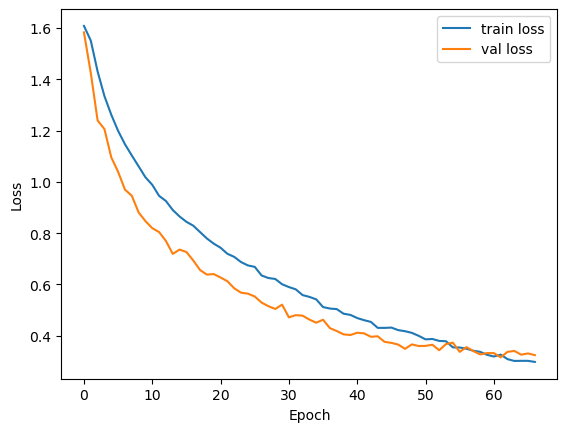

In [13]:
plt.plot(history.epoch, history.history['loss'], label='train loss')
plt.plot(history.epoch, history.history['val_loss'], label='val loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')

plt.legend();
plt.savefig('./img/loss_chormaCENS_SpecBW_Speccent_MFCC_RMS_tonnetz(6)adamax.png')

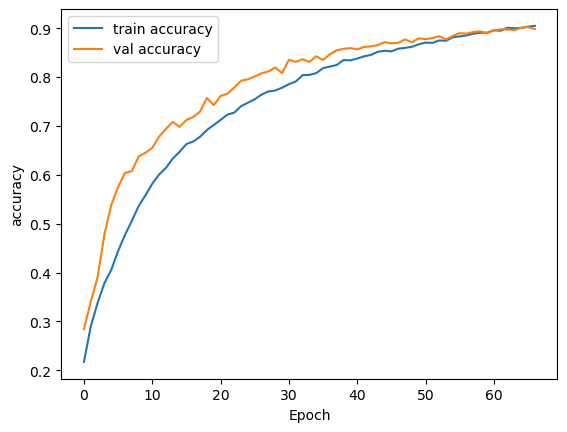

In [14]:
plt.plot(history.epoch, history.history['accuracy'], label='train accuracy')
plt.plot(history.epoch, history.history['val_accuracy'], label='val accuracy')
plt.xlabel('Epoch')
plt.ylabel('accuracy')
plt.legend();
plt.savefig('./img/accuracy_chormaCENS_SpecBW_Speccent_MFCC_RMS_tonnetz(6)adamax.png')

### 10.0 Model Evaluation

1) Macro Average Accuracy will be the main scoring metric to assess how well the model predict TP & TN.
1) Sub metric will be macro average of Precision & Recall
1) Additional metric is Matthew’s correlation coefficient, it ranges from -1 to 1 where 0 means the model is no better than random chance.

- Averaging Techniques for Multiclass classification
    - Macro Average : A simple arithmetic mean of all metrics across classes. This technique gives equal weights to all classes making it a good option for balanced classification tasks.
    - Weighted Average : Accounts for class imbalance by computing the average of binary metrics weighted by the number of samples of each class in the target.

Since our classes are balance we will be mostly looking at Macro average.

In [3]:
def load_test_eval(X_file,y_file,model):
    with h5py.File(X_file, 'r') as Xeval:
        X_eval = Xeval['X_dataset'][:]
    print(f'X shape --> {X_eval.shape}')
    print('')
    
    with h5py.File(y_file, 'r') as yeval:
        y_eval = yeval['y_dataset'][:]
    y_eval = np.array([label.decode() for label in y_eval])
    print(f'y len --> {len(y_eval)}')
    print('')
    
    encoder = OneHotEncoder()
    y_ohe = encoder.fit_transform(y_eval.reshape(-1,1)).toarray()
    print(f'Categories -->{encoder.categories_[0].tolist()}')
    print('')
    
    X_train, X_test, y_train, y_test = train_test_split(X_eval, y_ohe, test_size=0.20, random_state=42, stratify=y_ohe)
    
    clas_eval =load_model(model)
    return X_train, X_test, y_train, y_test , clas_eval, encoder

In [7]:
def plot_results(X_train, X_test, y_train, y_test , clas_eval, encoder):
    # create Prediction dataframe
    pred_test = clas_eval.predict(X_test)
    y_pred = encoder.inverse_transform(pred_test)
    y_test_decode = encoder.inverse_transform(y_test)
    cat = encoder.categories_[0].tolist()
    
    # Prepare and plot Confusion matrix
    cm = confusion_matrix(y_test_decode, y_pred, normalize='true')
    cm2 = confusion_matrix(y_test_decode, y_pred)
    cm_df = pd.DataFrame(cm , index = cat , columns = cat).round(2)

    plt.figure(figsize = (10, 8))
    sns.heatmap(cm_df, linecolor='white', cmap='Blues', linewidth=1, annot=True, fmt='')
    plt.title('Confusion Matrix(Norm by rows)', size=20)
    plt.xlabel('Predicted Labels', size=14)
    plt.ylabel('Actual Labels', size=14)
    plt.show();
    
    # Prepare and plot prediction bar chart
    pred = pd.DataFrame(cm2.diagonal(),index = cat, columns = ['Predicted Labels'])

    pred_df = pd.DataFrame(columns=['Predicted Labels', 'Actual Labels'])
    pred_df['Predicted Labels'] = y_pred.flatten()
    pred_df['Actual Labels'] = y_test_decode.flatten()
    
    ax = plt.subplots(figsize=(10,3))
    ax = sns.countplot(x=pred_df['Predicted Labels'],order=cat, color='gold',alpha =0.5,label ='Predicted Labels')
    ax = sns.barplot(x=pred.index, y=pred['Predicted Labels'],order=cat, color='darkblue',alpha =0.7,label ='Predicted Labels (TP only)')
    ax.axhline(pred_df['Actual Labels'].value_counts().values[0], color ='k',linestyle='--', label="Actual Labels")
    plt.title('Value counts Actual vs Predicted', size=20)
    ax.set(xlabel="Labels", ylabel="counts")
    ax.legend(loc="best")
    sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))
    plt.show();
    
    mcc = matthews_corrcoef(y_test_decode, y_pred)
    
    print('**Report**')
    print('-----------')
    print(f'MCC: {mcc:0.3f}')
    print('')
    print(classification_report(y_test_decode, y_pred))

#### 10.1 Baseline CNN model with 1 audio feature
***Features:***
1) Chroma CENS

- Train accuracy score is 41% and Test accuracy score is 39%. There is a 2% difference indicating that the model is moderately fitted
|  Data | Accuracy |  loss |
|:-----:|:--------:|:-----:|
| Train |   0.410  | 1.317|
|  Test |   0.394  | 1.351 |

- Macro avg F1 score is below 50%
| Emotion   | Precision | Recall | F1-score |
|:---------:|:---------:|:------:|:--------:|
| angry     |0.30|      0.85|      0.44|
| happy     |0.24|      0.11|      0.15|
| neutral   |0.50|      0.48|      0.49| 
| sad       |0.84|      0.45|      0.59| 
| surprise  |0.47|      0.08|      0.13|
| macro avg |0.47|      0.39|      0.36|
- MCC: 0.28 poorer than random chance

In [8]:
X_file = './X/X_chormaCENS(1).h5'
y_file = './y/y_chormaCENS(1).h5'
model = './model/chormaCENS(1)_baseline.h5'
X_train1, X_test1, y_train1, y_test1 , clas_eval1, encoder1 = load_test_eval(X_file,y_file,model)
X_test1 = np.expand_dims(X_test1, axis=3)

X shape --> (37863, 20, 350)

y len --> 37863

Categories -->['angry', 'happy', 'neutral', 'sad', 'surprise']



237/237 [==============================] - 1s 2ms/step


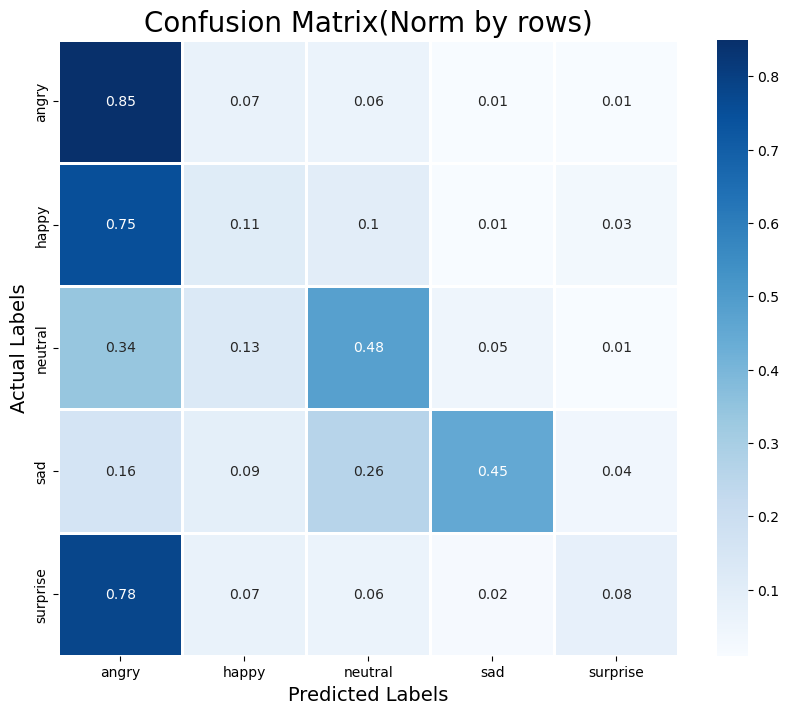

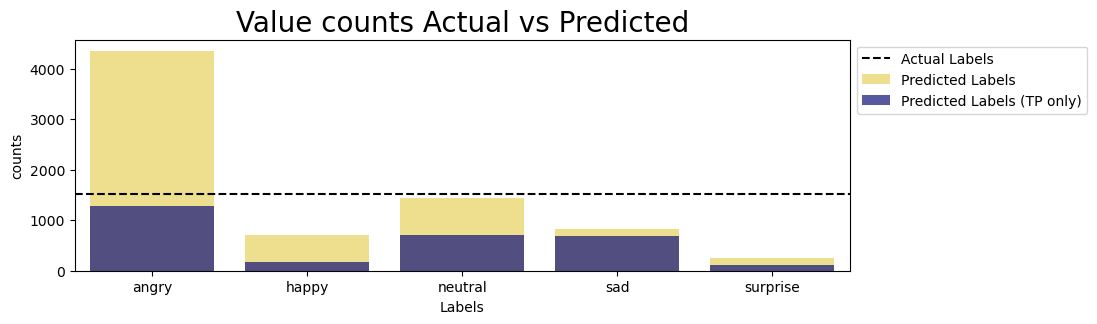

**Report**
-----------
MCC: 0.277

              precision    recall  f1-score   support

       angry       0.30      0.85      0.44      1518
       happy       0.24      0.11      0.15      1519
     neutral       0.50      0.48      0.49      1499
         sad       0.84      0.45      0.59      1519
    surprise       0.47      0.08      0.13      1518

    accuracy                           0.39      7573
   macro avg       0.47      0.39      0.36      7573
weighted avg       0.47      0.39      0.36      7573



In [9]:
plot_results(X_train1, X_test1, y_train1, y_test1 , clas_eval1, encoder1)

In [6]:
train_loss1, train_acc1 =  clas_eval1.evaluate(X_train1, y_train1, verbose=0)
print('Train_acc: %.3f, Train_loss: %.3f' % (train_acc1, train_loss1))

Train_acc: 0.410, Train_loss: 1.317


In [7]:
test_loss1, test_acc1 =  clas_eval1.evaluate(X_test1, y_test1, verbose=0)
print('Test_acc: %.3f, Test_loss: %.3f' % (test_acc1, test_loss1))

Test_acc: 0.394, Test_loss: 1.351


#### 10.2 Step-up CNN model with 2 audio features
***Features:***
1) Chroma CENS
1) Spectral Bandwith

- Train accuracy score is 62% and Test accuracy score is 59%. There is a 3% difference indicating that the model is moderately fitted
|  Data | Accuracy |  loss |
|:-----:|:--------:|:-----:|
|  Train  | 0.622     | 0.910  |
|   Test  | 0.589     | 0.995  |
- Macro avg F1 score is 59%. Adding Spectral Bandwith improves the model prediction capability by 23%
| Emotion   | Precision | Recall | F1-score |
|:---------:|:---------:|:------:|:--------:|
| angry     |0.60|      0.52|      0.56     | 
| happy     |0.40|      0.39|      0.39     |
| neutral   |0.63|      0.76|      0.69     |
| sad       |0.80|      0.71|      0.75     |
| surprise  |0.53|      0.57|      0.55     |
| macro avg |0.59|      0.59|      0.59     |
- MCC 0.488 which no better than random chance 

In [10]:
X_file = './X/X_chormaCENS_SpecBW(2).h5'
y_file = './y/y_chormaCENS_SpecBW(2).h5'
model = './model/chormaCENS_SpecBW(2).h5'
X_train2, X_test2, y_train2, y_test2 , clas_eval2, encoder2 = load_test_eval(X_file,y_file,model)

X shape --> (37863, 20, 350, 2)

y len --> 37863

Categories -->['angry', 'happy', 'neutral', 'sad', 'surprise']



237/237 [==============================] - 1s 4ms/step


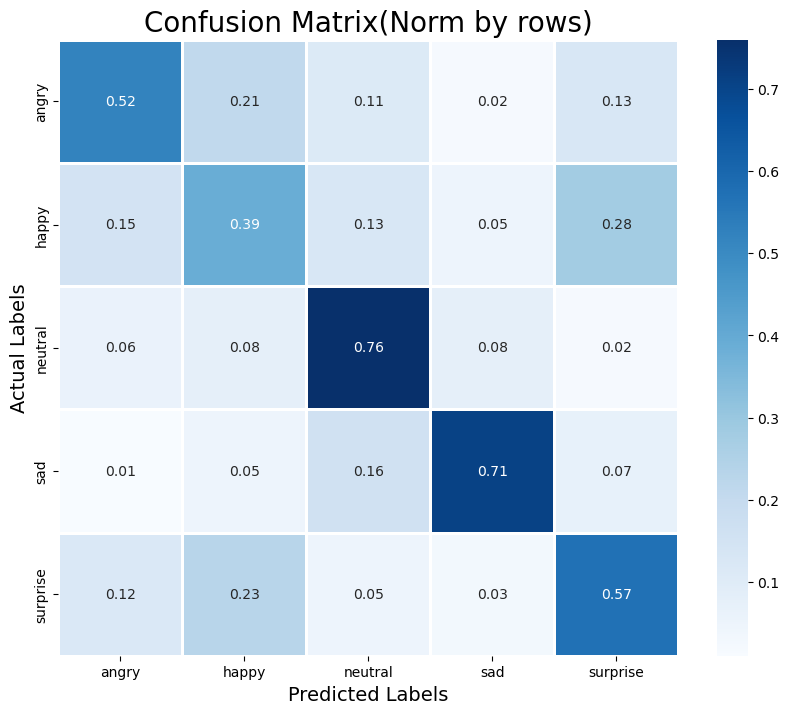

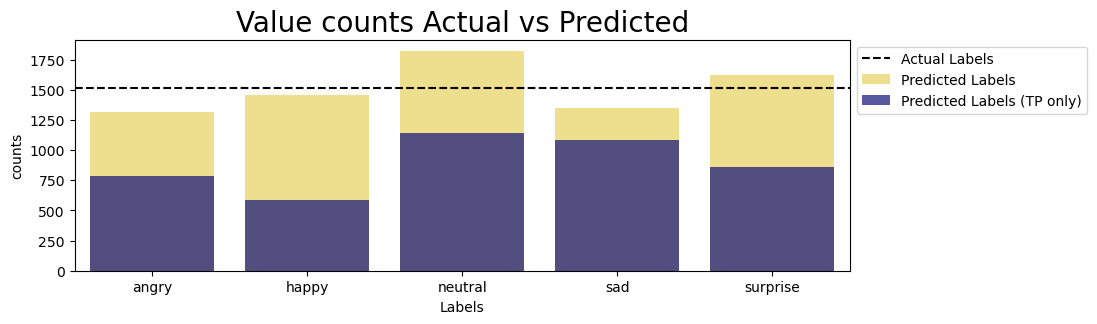

**Report**
-----------
MCC: 0.488

              precision    recall  f1-score   support

       angry       0.60      0.52      0.56      1518
       happy       0.40      0.39      0.39      1519
     neutral       0.63      0.76      0.69      1499
         sad       0.80      0.71      0.75      1519
    surprise       0.53      0.57      0.55      1518

    accuracy                           0.59      7573
   macro avg       0.59      0.59      0.59      7573
weighted avg       0.59      0.59      0.59      7573



In [11]:
plot_results(X_train2, X_test2, y_train2, y_test2 , clas_eval2, encoder2)

In [6]:
train_loss2, train_acc2 =  clas_eval2.evaluate(X_train2, y_train2, verbose=0)
print('Train_acc: %.3f, Train_loss: %.3f' % (train_acc2, train_loss2))

Train_acc: 0.622, Train_loss: 0.910


In [9]:
test_loss2, test_acc2 =  clas_eval2.evaluate(X_test2, y_test2, verbose=0)
print('Test_acc: %.3f, Test_loss: %.3f' % (test_acc2, test_loss2))

Test_acc: 0.589, Test_loss: 0.995


#### 10.3 Step-up CNN model with 3 audio features
***Features:***
1) Chroma CENS
1) Spectral Bandwith
1) Spectral Centroid

- Train accuracy score is 71% and Test accuracy score is 67%. There is a 4% difference indicating that the model is moderately fitted
|  Data | Accuracy |  loss |
|:-----:|:--------:|:-----:|
|  Train  | 0.866     | 0.397  |
|   Test  | 0.765     | 0.611 |
- Macro avg F1 score is 67%. Adding Spectral Centroid improves the model prediction capability by 8%
| Emotion   | Precision | Recall | F1-score |
|:---------:|:---------:|:------:|:--------:|
| angry     | 0.67|      0.63|      0.65     |
| happy     | 0.53|      0.39|      0.45     |
| neutral   | 0.74|      0.80|      0.77     |
| sad       | 0.80|      0.88|      0.84     |
| surprise  | 0.58|      0.67|      0.62     |
| macro avg | 0.67|      0.67|      0.67     |
- MCC 0.594 which is moderately better than random chance

In [12]:
X_file = './X/X_chormaCENS_SpecBW_SpecCent(3).h5'
y_file = './y/y_chormaCENS_SpecBW_SpecCent(3).h5'
model = './model/chormaCENS_SpecBW_SpecCent(3).h5'
X_train3, X_test3, y_train3, y_test3 , clas_eval3, encoder3 = load_test_eval(X_file,y_file,model)

X shape --> (37863, 20, 350, 3)

y len --> 37863

Categories -->['angry', 'happy', 'neutral', 'sad', 'surprise']



237/237 [==============================] - 1s 4ms/step


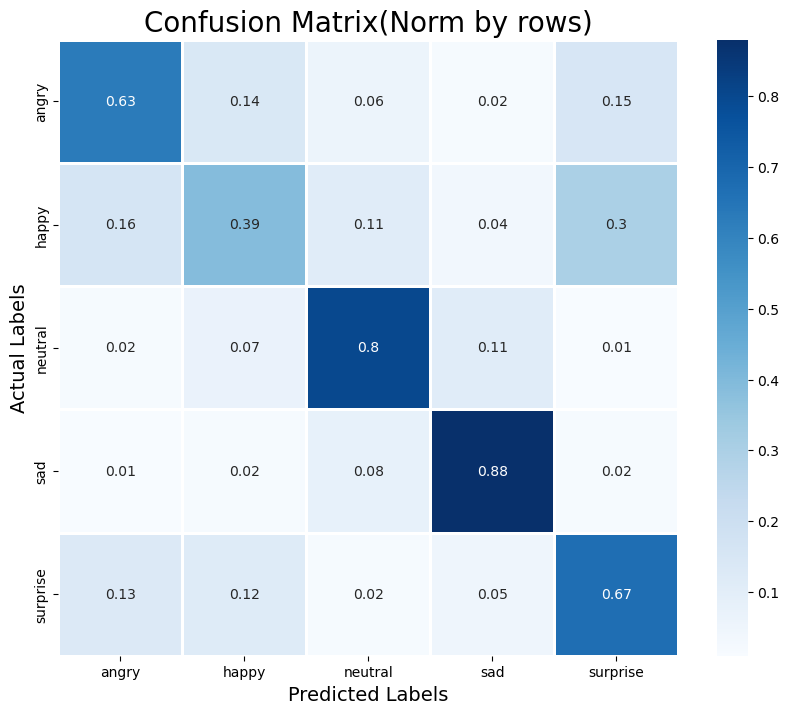

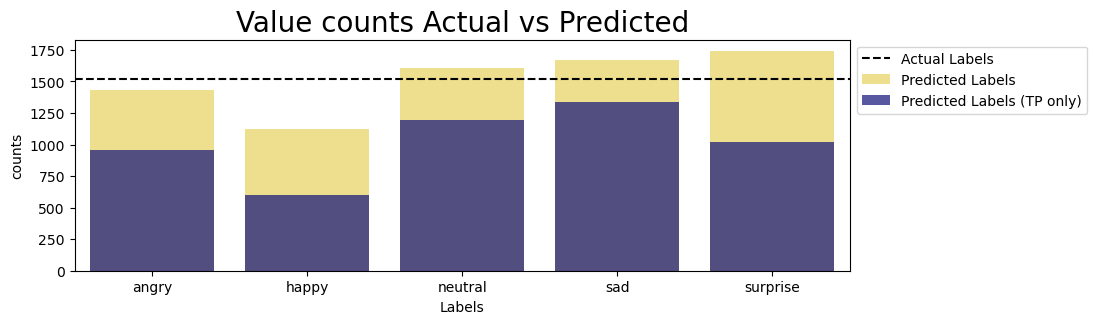

**Report**
-----------
MCC: 0.594

              precision    recall  f1-score   support

       angry       0.67      0.63      0.65      1518
       happy       0.53      0.39      0.45      1519
     neutral       0.74      0.80      0.77      1499
         sad       0.80      0.88      0.84      1519
    surprise       0.58      0.67      0.62      1518

    accuracy                           0.67      7573
   macro avg       0.67      0.67      0.67      7573
weighted avg       0.67      0.67      0.67      7573



In [13]:
plot_results(X_train3, X_test3, y_train3, y_test3 , clas_eval3, encoder3)

In [7]:
train_loss3, train_acc3 =  clas_eval3.evaluate(X_train3, y_train3, verbose=0)
print('Train_acc: %.3f, Train_loss: %.3f' % (train_acc3, train_loss3))

Train_acc: 0.710, Train_loss: 0.716


In [8]:
test_loss3, test_acc3 =  clas_eval3.evaluate(X_test3, y_test3, verbose=0)
print('Test_acc: %.3f, Test_loss: %.3f' % (test_acc3, test_loss3))

Test_acc: 0.674, Test_loss: 0.829


#### 10.4 Step-up CNN model with 4 audio features
***Features:***
1) Chroma CENS
1) Spectral Bandwith
1) Spectral Centroid
1) Zero Crossing Rate

- Train accuracy score is 63% and Test accuracy score is 60%. There is a 3% difference indicating that the model is moderately fited.
|  Data | Accuracy |  loss |
|:-----:|:--------:|:-----:|
|  Train  | 0.630    | 0.855  |
|   Test  | 0.607    | 0.909  |
- Macro avg F1 score is 61%. Adding Zero Crossing Rate reduces the model capability by 6%
| Emotion   | Precision | Recall | F1-score |
|:---------:|:---------:|:------:|:--------:|
| angry     | 0.52|      0.77|     0.62      |
| happy     | 0.40|      0.48|      0.43     |
| neutral   | 0.75|      0.76|      0.75     |
| sad       | 0.94|      0.71|      0.81     |
| surprise  | 0.59|      0.32|      0.41     |
| macro avg | 0.64|      0.61|      0.61     |
- MCC 0.517 which is no better than random chance

In [14]:
X_file = './X/X_chormaCENS_SpecBW_Speccent_ZCR(4).h5'
y_file = './y/y_chormaCENS_SpecBW_Speccent_ZCR(4).h5'
model = './model/chormaCENS_SpecBW_Speccent_ZCR(4).h5'
X_train4, X_test4, y_train4, y_test4 , clas_eval4, encoder4 = load_test_eval(X_file,y_file,model)

X shape --> (37863, 20, 350, 4)

y len --> 37863

Categories -->['angry', 'happy', 'neutral', 'sad', 'surprise']



237/237 [==============================] - 1s 4ms/step


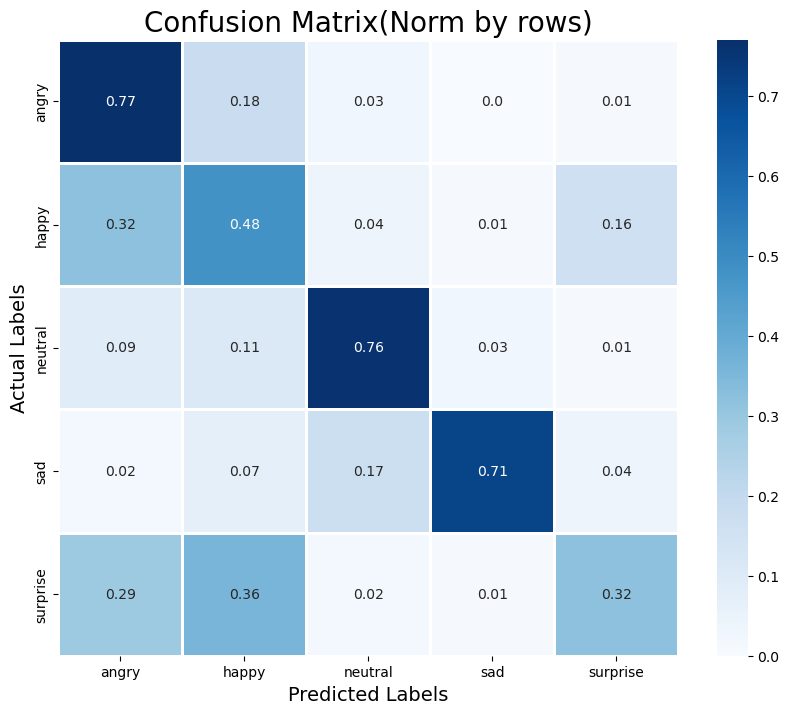

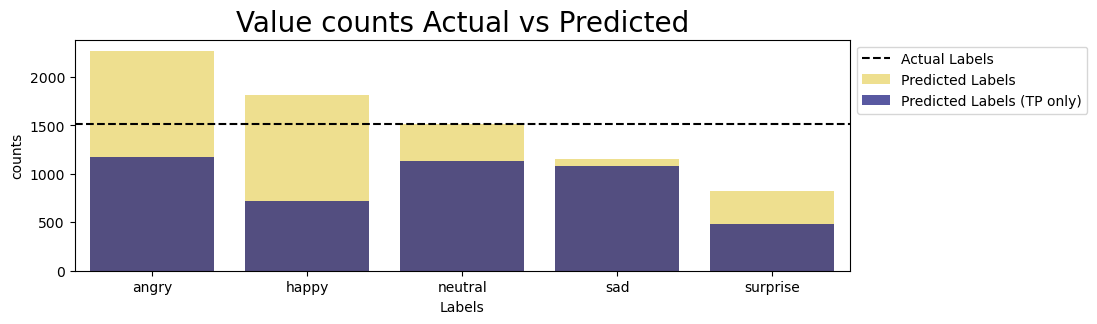

**Report**
-----------
MCC: 0.517

              precision    recall  f1-score   support

       angry       0.52      0.77      0.62      1518
       happy       0.40      0.48      0.43      1519
     neutral       0.75      0.76      0.75      1499
         sad       0.94      0.71      0.81      1519
    surprise       0.59      0.32      0.41      1518

    accuracy                           0.61      7573
   macro avg       0.64      0.61      0.61      7573
weighted avg       0.64      0.61      0.61      7573



In [15]:
plot_results(X_train4, X_test4, y_train4, y_test4 , clas_eval4, encoder4)

In [8]:
train_loss4, train_acc4 =  clas_eval4.evaluate(X_train4, y_train4, verbose=0)
print('Train_acc: %.3f, Train_loss: %.3f' % (train_acc4, train_loss4))

Train_acc: 0.630, Train_loss: 0.855


In [9]:
test_loss4, test_acc4 =  clas_eval4.evaluate(X_test4, y_test4, verbose=0)
print('Test_acc: %.3f, Test_loss: %.3f' % (test_acc4, test_loss4))

Test_acc: 0.607, Test_loss: 0.909


#### 10.5 Step-up CNN model with 4 audio features v2
***Features:***
1) Chroma CENS
1) Spectral Bandwith
1) Spectral Centroid
1) MFCC

- Train accuracy score is 94% and Test accuracy score is 89%. There is a 5% difference indicating that the model is generally fited.
|  Data | Accuracy |  loss |
|:-----:|:--------:|:-----:|
|  Train  | 0.942    | 0.186  |
|   Test  | 0.896    | 0.358  |
- Macro avg F1 score is 90%. Adding MFCC inplace for ZCR improves the model capability by 29%
| Emotion   | Precision | Recall | F1-score |
|:---------:|:---------:|:------:|:--------:|
| angry     | 0.88|      0.93|      0.91     |
| happy     | 0.82|      0.82|      0.82     |
| neutral   | 0.91|      0.95|      0.93     |
| sad       | 0.95|      0.93|      0.94     |
| surprise  | 0.91|      0.84|      0.87     |
| macro avg | 0.90|      0.90|      0.90     |
- MCC 0.870 which is excecptionally better than random chance

In [16]:
X_file = './X/X_chormaCENS_SpecBW_Speccent_MFCC(4).h5'
y_file = './y/y_chormaCENS_SpecBW_Speccent_MFCC(4).h5'
model = './model/chormaCENS_SpecBW_Speccent_MFCC(4).h5'
X_train5, X_test5, y_train5, y_test5 , clas_eval5, encoder5 = load_test_eval(X_file,y_file,model)

X shape --> (37863, 20, 350, 4)

y len --> 37863

Categories -->['angry', 'happy', 'neutral', 'sad', 'surprise']



237/237 [==============================] - 1s 4ms/step


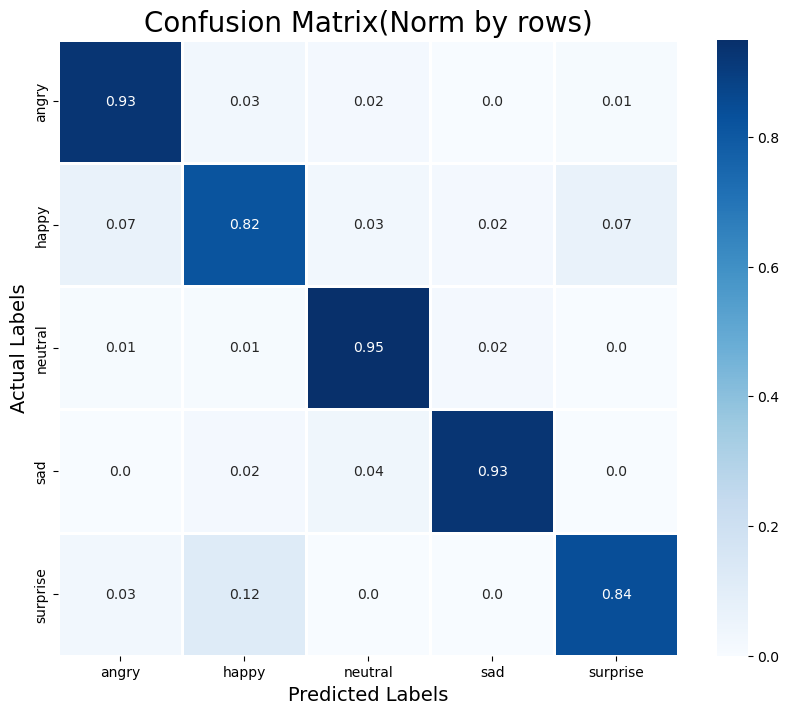

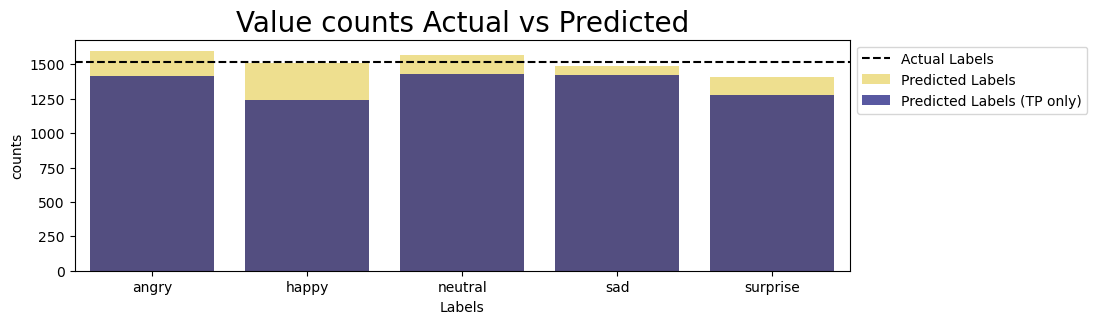

**Report**
-----------
MCC: 0.870

              precision    recall  f1-score   support

       angry       0.88      0.93      0.91      1518
       happy       0.82      0.82      0.82      1519
     neutral       0.91      0.95      0.93      1499
         sad       0.95      0.93      0.94      1519
    surprise       0.91      0.84      0.87      1518

    accuracy                           0.90      7573
   macro avg       0.90      0.90      0.90      7573
weighted avg       0.90      0.90      0.90      7573



In [17]:
plot_results(X_train5, X_test5, y_train5, y_test5 , clas_eval5, encoder5)

In [7]:
train_loss5, train_acc5 =  clas_eval5.evaluate(X_train5, y_train5, verbose=0)
print('Train_acc: %.3f, Train_loss: %.3f' % (train_acc5, train_loss5))

Train_acc: 0.942, Train_loss: 0.186


In [7]:
test_loss5, test_acc5=  clas_eval5.evaluate(X_test5, y_test5, verbose=0)
print('Test_acc: %.3f, Test_loss: %.3f' % (test_acc5, test_loss5))

Test_acc: 0.896, Test_loss: 0.358


#### 10.6 Step-up CNN model with 5 audio features
***Features:***
1) Chroma CENS
1) Spectral Bandwith
1) Spectral Centroid
1) Mel-frequency cepstral coefficients(MFCC) Normalized
1) Spectral Contrast

- Train accuracy score is 87% and Test accuracy score is 84%. There is a 3% difference indicating that the model fitted moderately.
|  Data | Accuracy |  loss |
|:-----:|:--------:|:-----:|
|  Train  | 0.875     | 0.337  |
|   Test  | 0.840     | 0.449  |
- Macro avg F1 score is 84%. Adding Spectral Contrast reduces the model prediction capability by 6%
| Emotion   | Precision | Recall | F1-score |
|:---------:|:---------:|:------:|:--------:|
| angry     | 0.92|      0.76|      0.84     |
| happy     | 0.69|      0.71|      0.70     |
| neutral   | 0.94|      0.89|      0.91     |
| sad       | 0.90|      0.96|      0.92     |
| surprise  | 0.78|      0.88|      0.83     |
| macro avg | 0.85|      0.84|      0.84     |
- MCC 0.801 which is adequate and better than random chance

In [18]:
X_file = './X/X_chormaCENS_SpecBW_Speccent_MFCC_cont(5).h5'
y_file = './y/y_chormaCENS_SpecBW_Speccent_MFCC_cont(5).h5'
model = './model/chormaCENS_SpecBW_Speccent_MFCC_cont(5).h5'
X_train6, X_test6, y_train6, y_test6 , clas_eval6, encoder6 = load_test_eval(X_file,y_file,model)

X shape --> (37863, 20, 350, 5)

y len --> 37863

Categories -->['angry', 'happy', 'neutral', 'sad', 'surprise']



237/237 [==============================] - 1s 4ms/step


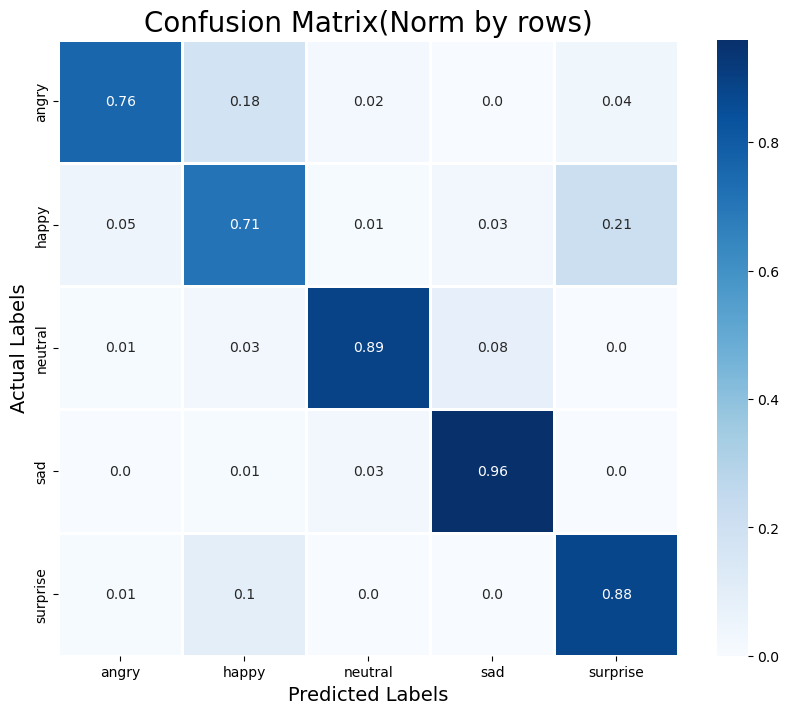

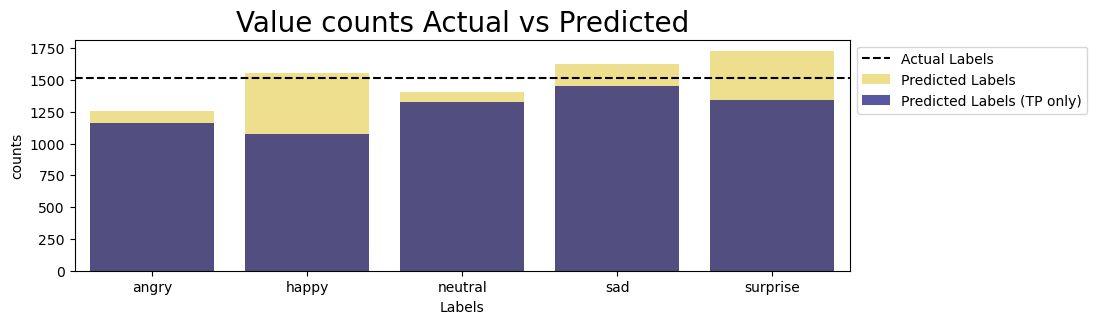

**Report**
-----------
MCC: 0.801

              precision    recall  f1-score   support

       angry       0.92      0.76      0.84      1518
       happy       0.69      0.71      0.70      1519
     neutral       0.94      0.89      0.91      1499
         sad       0.90      0.96      0.92      1519
    surprise       0.78      0.88      0.83      1518

    accuracy                           0.84      7573
   macro avg       0.85      0.84      0.84      7573
weighted avg       0.85      0.84      0.84      7573



In [19]:
plot_results(X_train6, X_test6, y_train6, y_test6 , clas_eval6, encoder6)

In [6]:
train_loss6, train_acc6 =  clas_eval6.evaluate(X_train6, y_train6, verbose=0)
print('Train_acc: %.3f, Train_loss: %.3f' % (train_acc6, train_loss6))

Train_acc: 0.875, Train_loss: 0.337


In [7]:
test_loss6, test_acc6 = clas_eval6.evaluate(X_test6, y_test6, verbose=0)
print(f'Test_acc: {test_acc6:0.3f}, Test_loss: {test_loss6:0.3f}')

Test_acc: 0.840, Test_loss: 0.449


#### 10.7 Step-up CNN model with 5 audio features v2
***Features:***
1) Chroma CENS
1) Spectral Bandwith
1) Spectral Centroid
1) Mel-frequency cepstral coefficients(MFCC) Normalized
1) Chroma STFT

- Train accuracy score is 83% and Test accuracy score is 80%. There is a 3% difference indicating that the model generally fitted.
|  Data | Accuracy |  loss |
|:-----:|:--------:|:-----:|
|  Train  | 0.833     | 0.449|
|   Test  | 0.803     | 0.529 |
- Macro avg F1 score is 80%. Adding Chroma STFT reduces the model prediction capability by 10%
| Emotion   | Precision | Recall | F1-score |
|:---------:|:---------:|:------:|:--------:|
| angry     | 0.80|      0.79|      0.79      |
| happy     | 0.63|      0.69|      0.66      |
| neutral   | 0.86|      0.88|      0.87      |
| sad       | 0.88|      0.93|      0.90      |
| surprise  | 0.87|      0.72|      0.79      |
| macro avg | 0.81|      0.80|      0.80      |
- MCC 0.755 which is adequately better than random chance

In [5]:
X_file = './X/X_chormaCENS_SpecBW_Speccent_MFCC_chromastft(5).h5'
y_file = './y/y_chormaCENS_SpecBW_Speccent_MFCC_chromastft(5).h5'
model = './model/chormaCENS_SpecBW_Speccent_MFCC_chromastft(5).h5'
X_train7, X_test7, y_train7, y_test7 , clas_eval7, encoder7 = load_test_eval(X_file,y_file,model)

X shape --> (37863, 20, 350, 5)

y len --> 37863

Categories -->['angry', 'happy', 'neutral', 'sad', 'surprise']



237/237 [==============================] - 3s 5ms/step


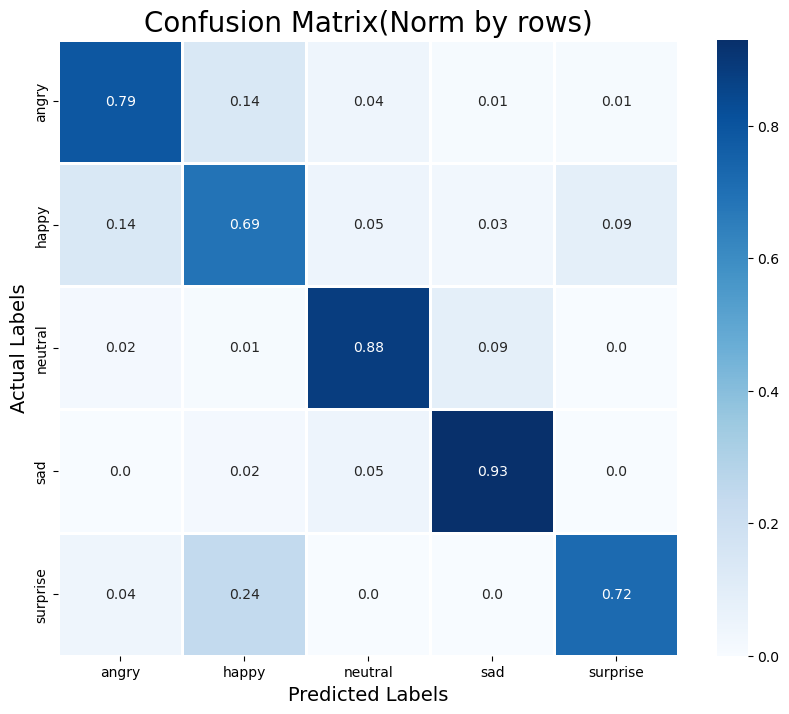

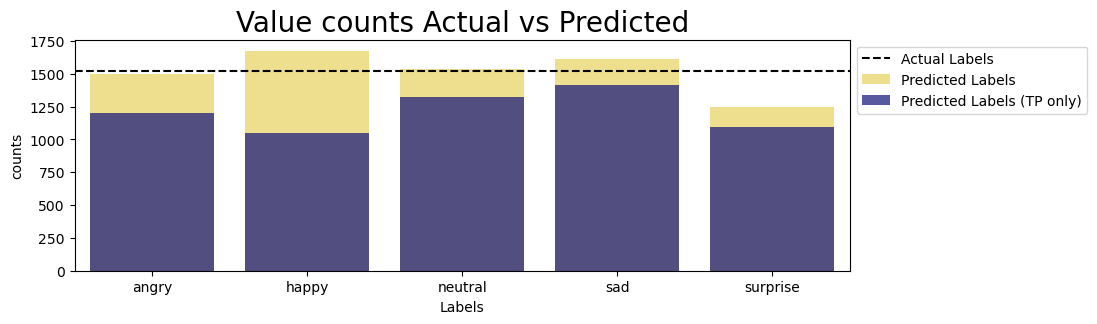

**Report**
-----------
MCC: 0.755

              precision    recall  f1-score   support

       angry       0.80      0.79      0.79      1518
       happy       0.63      0.69      0.66      1519
     neutral       0.86      0.88      0.87      1499
         sad       0.88      0.93      0.90      1519
    surprise       0.87      0.72      0.79      1518

    accuracy                           0.80      7573
   macro avg       0.81      0.80      0.80      7573
weighted avg       0.81      0.80      0.80      7573



In [6]:
plot_results(X_train7, X_test7, y_train7, y_test7 , clas_eval7, encoder7)

In [7]:
train_loss7, train_acc7 =  clas_eval7.evaluate(X_train7, y_train7, verbose=0)
print('Train_acc: %.3f, Train_loss: %.3f' % (train_acc7, train_loss7))

Train_acc: 0.833, Train_loss: 0.449


In [6]:
test_loss7, test_acc7 = clas_eval7.evaluate(X_test7, y_test7, verbose=0)
print(f'Test_acc: {test_acc7:0.3f}, Test_loss: {test_loss7:0.3f}')

Test_acc: 0.803, Test_loss: 0.529


#### 10.8 Step-up CNN model with 5 audio features v3
***Features:***
1) Chroma CENS
1) Spectral Bandwith
1) Spectral Centroid
1) Mel-frequency cepstral coefficients(MFCC) Normalized
1) Root-Mean-Square (RMS)

- Train accuracy score is 90% and Test accuracy score is 87%. There is a 3% difference indicating that the model generally fitted.
|  Data | Accuracy |  loss |
|:-----:|:--------:|:-----:|
|  Train  | 0.907     | 0.258 |
|   Test  | 0.873     | 0.359 |
- Macro avg F1 score is 87%. Adding Root-Mean-Square (RMS) reduces the model prediction capability by 3%
| Emotion   | Precision | Recall | F1-score |
|:---------:|:---------:|:------:|:--------:|
| angry     | 0.85|      0.93|      0.89     |
| happy     | 0.74|      0.80|      0.77     |
| neutral   | 0.93|      0.95|      0.94     |
| sad       | 0.95|      0.94|      0.94     |
| surprise  | 0.93|      0.74|      0.82     |
| macro avg | 0.88|      0.87|      0.87     |
- MCC 0.842 which is adequately better than random chance

In [21]:
X_file = './X/X_chormaCENS_SpecBW_Speccent_MFCC_RMS(5).h5'
y_file = './y/y_chormaCENS_SpecBW_Speccent_MFCC_RMS(5).h5'
model = './model/chormaCENS_SpecBW_Speccent_MFCC_RMS(5).h5'
X_train8, X_test8, y_train8, y_test8 , clas_eval8, encoder8 = load_test_eval(X_file,y_file,model)

X shape --> (37863, 20, 350, 5)

y len --> 37863

Categories -->['angry', 'happy', 'neutral', 'sad', 'surprise']



237/237 [==============================] - 1s 4ms/step


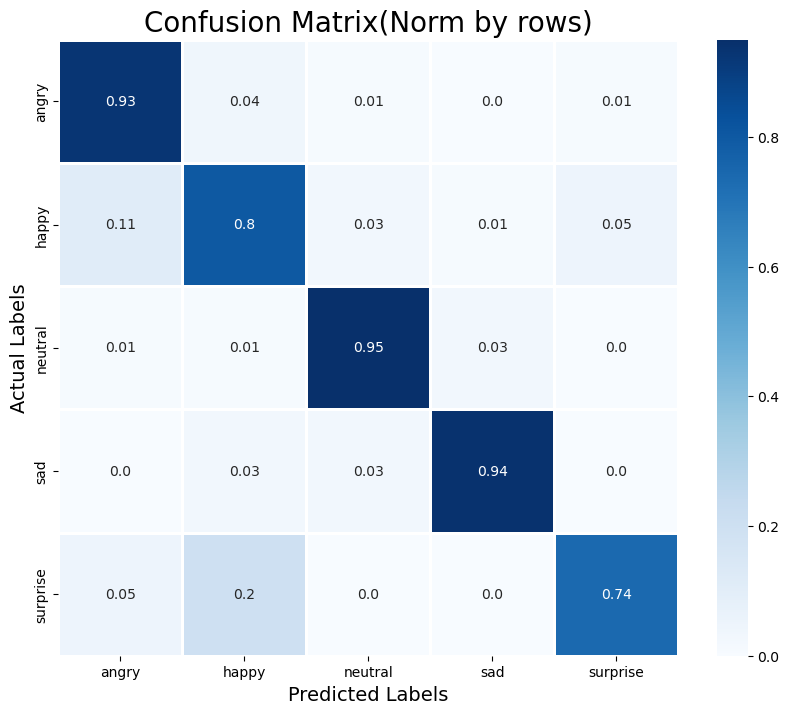

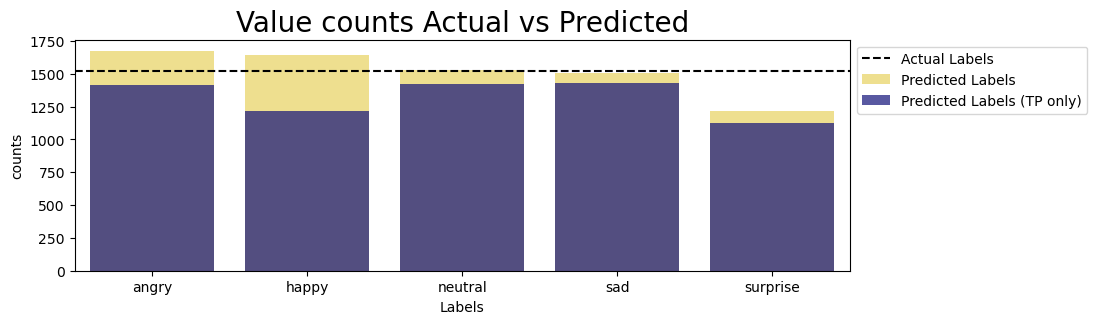

**Report**
-----------
MCC: 0.842

              precision    recall  f1-score   support

       angry       0.85      0.93      0.89      1518
       happy       0.74      0.80      0.77      1519
     neutral       0.93      0.95      0.94      1499
         sad       0.95      0.94      0.94      1519
    surprise       0.93      0.74      0.82      1518

    accuracy                           0.87      7573
   macro avg       0.88      0.87      0.87      7573
weighted avg       0.88      0.87      0.87      7573



In [22]:
plot_results(X_train8, X_test8, y_train8, y_test8 , clas_eval8, encoder8)

In [8]:
train_loss8, train_acc8 =  clas_eval8.evaluate(X_train8, y_train8, verbose=0)
print('Train_acc: %.3f, Train_loss: %.3f' % (train_acc8, train_loss8))

Train_acc: 0.907, Train_loss: 0.258


In [9]:
test_loss8, test_acc8 = clas_eval8.evaluate(X_test8, y_test8, verbose=0)
print(f'Test_acc: {test_acc8:0.3f}, Test_loss: {test_loss8:0.3f}')

Test_acc: 0.873, Test_loss: 0.359


#### 10.9 Step-up CNN model with 6 audio features
***Features:***
1) Chroma CENS
1) Spectral Bandwith
1) Spectral Centroid
1) Mel-frequency cepstral coefficients(MFCC) Normalized
1) Root-Mean-Square (RMS)
1) Tonnetz

- Train accuracy score is 81% and Test accuracy score is 79%. There is a 2% difference indicating that the model moderately fitted.
|  Data | Accuracy |  loss |
|:-----:|:--------:|:-----:|
|  Train  | 0.819     | 0.503 |
|   Test  | 0.790     | 0.578 |
- Macro avg F1 score is 79%. Adding Tonnetz (RMS) reduces the model prediction capability by 11%
| Emotion   | Precision | Recall | F1-score |
|:---------:|:---------:|:------:|:--------:|
| angry     | 0.87|      0.76|      0.81     |
| happy     | 0.62|      0.73|      0.67     |
| neutral   | 0.73|      0.96|      0.83     |
| sad       | 0.95|      0.85|      0.90     |
| surprise  | 0.88|      0.66|      0.75     |
| macro avg | 0.81|      0.79|      0.79     |

- MCC 0.741 which is adequately better than random chance

In [23]:
X_file = './X/X_chormaCENS_SpecBW_Speccent_MFCC_RMS_tonnetz(6).h5'
y_file = './y/y_chormaCENS_SpecBW_Speccent_MFCC_RMS_tonnetz(6).h5'
model = './model/chormaCENS_SpecBW_Speccent_MFCC_RMS_tonnetz(6).h5'
X_train9, X_test9, y_train9, y_test9 , clas_eval9, encoder9 = load_test_eval(X_file,y_file,model)

X shape --> (37863, 20, 350, 6)

y len --> 37863

Categories -->['angry', 'happy', 'neutral', 'sad', 'surprise']



237/237 [==============================] - 1s 4ms/step


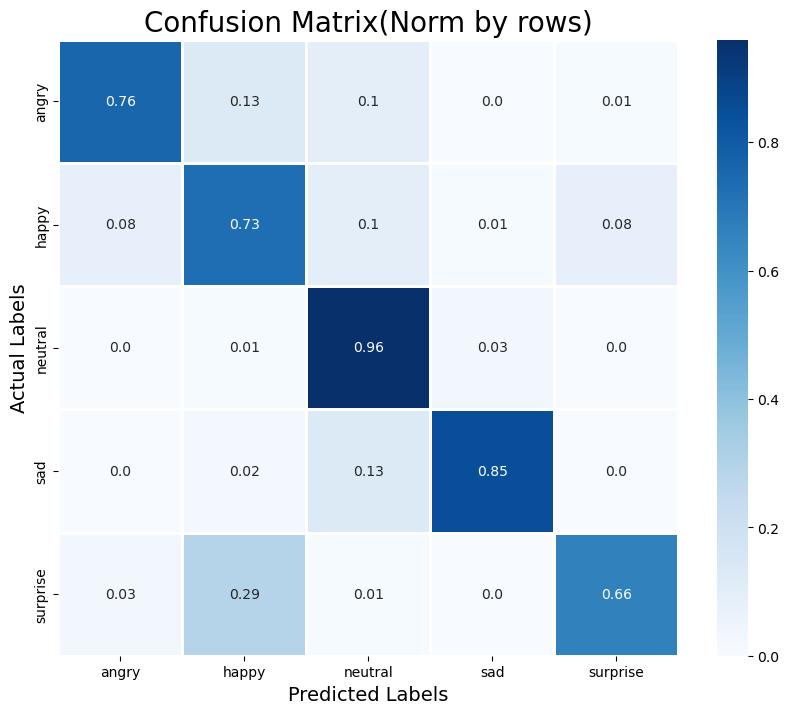

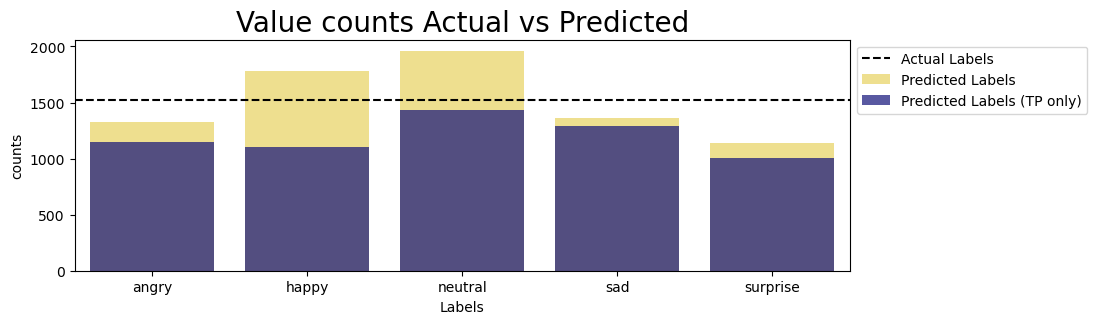

**Report**
-----------
MCC: 0.741

              precision    recall  f1-score   support

       angry       0.87      0.76      0.81      1518
       happy       0.62      0.73      0.67      1519
     neutral       0.73      0.96      0.83      1499
         sad       0.95      0.85      0.90      1519
    surprise       0.88      0.66      0.75      1518

    accuracy                           0.79      7573
   macro avg       0.81      0.79      0.79      7573
weighted avg       0.81      0.79      0.79      7573



In [24]:
plot_results(X_train9, X_test9, y_train9, y_test9 , clas_eval9, encoder9)

In [6]:
train_loss9, train_acc9 =  clas_eval9.evaluate(X_train9, y_train9, verbose=0)
print('Train_acc: %.3f, Train_loss: %.3f' % (train_acc9, train_loss9))

Train_acc: 0.819, Train_loss: 0.503


In [5]:
test_loss9, test_acc9 = clas_eval9.evaluate(X_test9, y_test9, verbose=0)
print(f'Test_acc: {test_acc9:0.3f}, Test_loss: {test_loss9:0.3f}')

Test_acc: 0.790, Test_loss: 0.578


#### 10.10 Step-up CNN model with 6 audio feature with Adamax
***Features:***
1) Chroma CENS
1) Spectral Bandwith
1) Spectral Centroid
1) Mel-frequency cepstral coefficients(MFCC) Normalized
1) Root-Mean-Square (RMS)
1) Tonnetz

***Optimizer:***
- Adamax[(source)](https://keras.io/api/optimizers/adamax/)

AdaMax algorithm is an extension to the Adaptive Movement Estimation (Adam) Optimization algorithm. More broadly, is an extension to the Gradient Descent Optimization algorithm. Adamax is sometimes superior to adam, specially in models with embeddings.

- Train accuracy score is 9% and Test accuracy score is 90%. There is a 4% difference indicating that the model fitted moderately.
|  Data | Accuracy |  loss |
|:-----:|:--------:|:-----:|
|  Train  |0.943| 0.177|
|   Test  |0.908| 0.304|
- Macro avg F1 score is 91%. Changing to Adamax optimizer along with tuning improves the model prediction capability by 11%.
| Emotion   | Precision | Recall | F1-score |
|:---------:|:---------:|:------:|:--------:|
| angry     | 0.92|      0.92|      0.92    |
| happy     | 0.86|      0.83|      0.85    |
| neutral   | 0.91|      0.96|      0.94    |
| sad       | 0.97|      0.92|      0.94    |
| surprise  | 0.88|      0.90|      0.89    |
| macro avg | 0.91|      0.91|      0.91    |
- MCC 0.885 which is exceptionaly better than random chance

In [25]:
X_file = './X/X_chormaCENS_SpecBW_Speccent_MFCC_RMS_tonnetz(6).h5'
y_file = './y/y_chormaCENS_SpecBW_Speccent_MFCC_RMS_tonnetz(6).h5'
model = './model/chormaCENS_SpecBW_Speccent_MFCC_RMS_tonnetz(6)adamax.h5'
X_train10, X_test10, y_train10, y_test10 , clas_eval10, encoder10 = load_test_eval(X_file,y_file,model)

X shape --> (37863, 20, 350, 6)

y len --> 37863

Categories -->['angry', 'happy', 'neutral', 'sad', 'surprise']



237/237 [==============================] - 1s 4ms/step


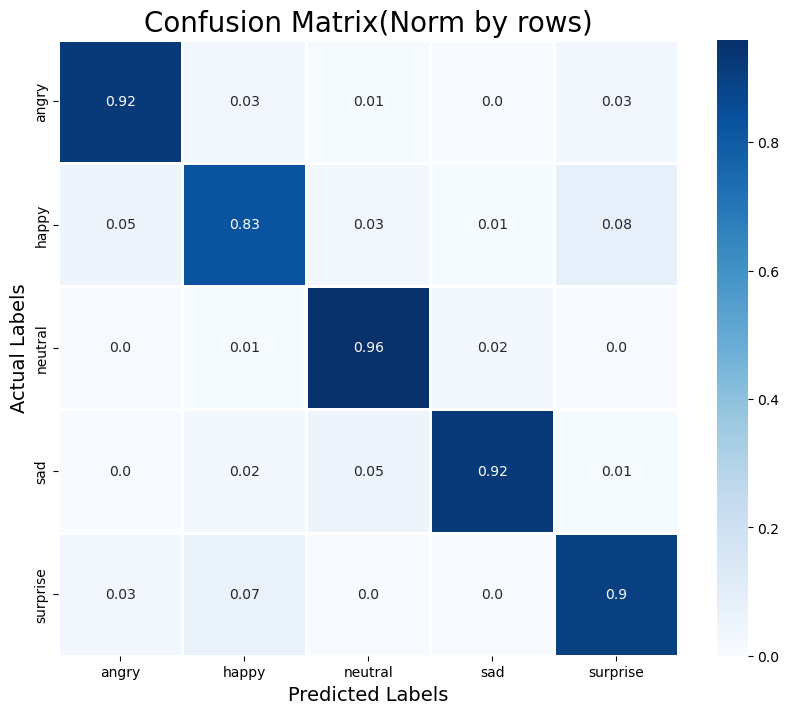

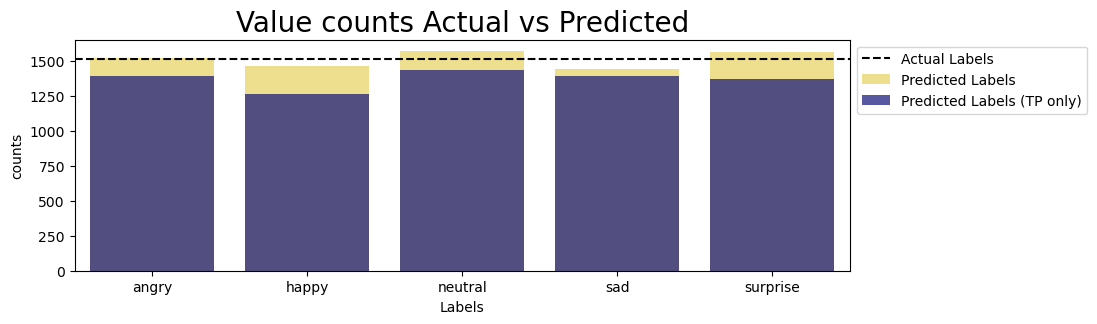

**Report**
-----------
MCC: 0.885

              precision    recall  f1-score   support

       angry       0.92      0.92      0.92      1518
       happy       0.86      0.83      0.85      1519
     neutral       0.91      0.96      0.94      1499
         sad       0.97      0.92      0.94      1519
    surprise       0.88      0.90      0.89      1518

    accuracy                           0.91      7573
   macro avg       0.91      0.91      0.91      7573
weighted avg       0.91      0.91      0.91      7573



In [26]:
plot_results(X_train10, X_test10, y_train10, y_test10 , clas_eval10, encoder10)

In [5]:
train_loss10, train_acc10 =  clas_eval10.evaluate(X_train10, y_train10, verbose=0)
print('Train_acc: %.3f, Train_loss: %.3f' % (train_acc10, train_loss10))

Train_acc: 0.943, Train_loss: 0.177


In [5]:
test_loss10, test_acc10 =  clas_eval10.evaluate(X_test10, y_test10, verbose=0)
print('Test_acc: %.3f, Test_loss: %.3f' % (test_acc10, test_loss10))

Test_acc: 0.908, Test_loss: 0.304


#### Model Summary

- Increasing the complexity of the CNN able to improve the scores to a certain extent.
- Increasing the the number of features generally improves the scores. It also depending on what kind of feautures are used
- Changing Optimizer to Adamax from adam improves the scores by quite a big margin

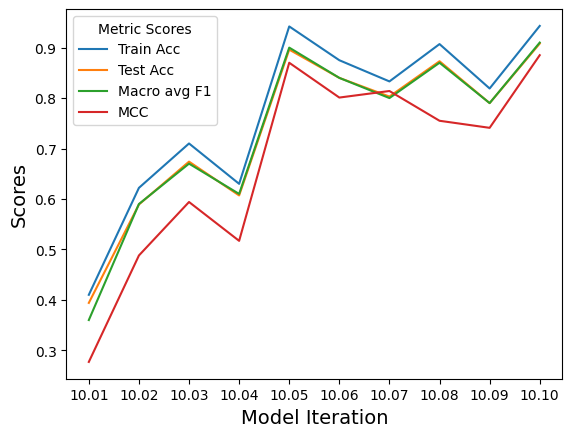

In [3]:
scores_df= pd.read_csv('Scores.txt',sep ='\t').set_index('Scores')
sns.lineplot(data= scores_df.loc['Train Acc'])
sns.lineplot(data= scores_df.loc['Test Acc'])
sns.lineplot(data= scores_df.loc['Macro avg F1'])
sns.lineplot(data= scores_df.loc['MCC'])
plt.xlabel('Model Iteration', size=14)
plt.ylabel('Scores', size=14)
plt.legend(labels= ['Train Acc', 'Test Acc', 'Macro avg F1','MCC'],title = "Metric Scores");

### 11.0 Best model

The best model using 6 features and Adamax optimizer with the best metrics scores:
- Train Acc: 0.943
- Test Acc: 0.908
- Train loss: 0.177
- Test loss: 0.304
- Macro avg F1: 0.910
- MCC: 0.885

***Features used:***
1) Chroma CENS
1) Spectral Bandwith
1) Spectral Centroid
1) Mel-frequency cepstral coefficients(MFCC) Normalized
1) Root-Mean-Square (RMS)
1) Tonnetz

***Optimizer used:***
- Adamax


- **CNN Architecture**

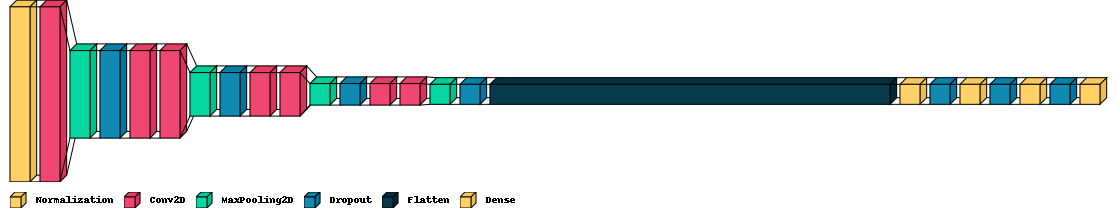

In [69]:
clas_eval10.add(visualkeras.SpacingDummyLayer(spacing=100))
visualkeras.layered_view(clas_eval10,legend=True,scale_xy = 0.5,to_file = './output.png')

- Train and Validation accuracy scores are comparable this indicates that the Model is moderately trained.
![acc](./img/bestmodelacc.png)

- The training was stopped with EarlyStopping() when the Validation loss score starts to saturate
![loss](./img/bestmodelloss.png)

- Below is the Confusion Matrix for this Model normalized by rows indicating Recall scores which are over 80%.

![cm](./img/bestcm.png)

### 12.0 Conlusion and Recommendations 

#### 12.1 Conclusion

- **Best Model CNN**
    - Optimizer Adamax
    - 6 audio features
    - Step up conv2d layers
    - Step down dense layers
The model capability to predict each class(emotion) with a Macro average F1 score of  and MCC score of. Model is not overfitted or underfitting after implementing Drop out and early stop which resulted in on % difference in train and test scores

- **Application benefits**
    - Improved emotional awareness.
    - Better Social Intelligence
    - Overall lifestyle change
With the Audio classifier Application deployed, the targeted group can now be able to have a basic understanding of the 5 emotions through article based or video based learning. This will in turn improve thier emotional awareness and Social inteligence

#### 12.2 Recommendations

- **Automation implementation**
    - Taking advantage of computer to carry out basic repetitive task

- **Deployment to Education sector**
    - Learning aid
    - Promote social awareness

- **Integration to other services**
    - Networking systems where connecting and interaction with people in similar situations are possible.
    
- **Other Applications**
    -  Customer services: real-time emotional analyzers to streamline services or early detection system to prevent conversations from escalating which may result in tarnished reputation or customer churn rate.
    - Healthcare: Healthcare professionals can use it as a baseline for patients' mental health and adjust their needs accordingly. Mental health is also essential for their road to recovery.
    - Personal application: boosting self cofidence from knowing how you protray yourself to others. 